In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import imageio
import io
import pandas as pd
from tqdm import tqdm
from typing import Union, Optional, Dict, Tuple, List
import pickle
from sklearn.model_selection import train_test_split

import torch
from torch_geometric.data import Data
from mpl_toolkits.mplot3d import Axes3D

class BaseballPitchProcessor:
    """
    A unified class to visualize baseball pitching data and convert it 
    to PyTorch Geometric datasets for next-step prediction.
    Adapted from tennis serve processor for OpenBiomechanics baseball data.
    COMPLETE VERSION with normalization support.
    """
    
    def __init__(self, base_dir: Union[str, Path]):
        self.base_dir = Path(base_dir)
        self.data_path = self.base_dir / "data"
        self.full_sig_path = self.data_path / "full_sig"
        self.metadata_path = self.data_path / "metadata.csv"
        
        # Load all data
        self.metadata = self._load_metadata()
        self.landmarks = pd.read_csv(self.full_sig_path / "landmarks.csv")
        self.joint_angles = pd.read_csv(self.full_sig_path / "joint_angles.csv")
        self.joint_velos = pd.read_csv(self.full_sig_path / "joint_velos.csv")
        
        # Extract joint names from landmarks columns
        self.joint_names = self._extract_joint_names()
        
        # Define skeleton connections based on anatomical structure
        self.skeleton_edges = [
            # PELVIS (hip girdle)
            ('rear_hip', 'lead_hip'),
            
            # TRUNK/SPINE
            ('rear_hip', 'thorax_prox'),
            ('lead_hip', 'thorax_prox'),
            ('thorax_prox', 'thorax_dist'),
            
            # THROWING ARM
            ('thorax_dist', 'shoulder_jc'),
            ('shoulder_jc', 'elbow_jc'),
            ('elbow_jc', 'wrist_jc'),
            ('wrist_jc', 'hand_jc'),
            
            # GLOVE ARM
            ('thorax_dist', 'glove_shoulder_jc'),
            ('glove_shoulder_jc', 'glove_elbow_jc'),
            ('glove_elbow_jc', 'glove_wrist_jc'),
            ('glove_wrist_jc', 'glove_hand_jc'),
            
            # LEAD LEG
            ('lead_hip', 'lead_knee_jc'),
            ('lead_knee_jc', 'lead_ankle_jc'),
            
            # REAR LEG
            ('rear_hip', 'rear_knee_jc'),
            ('rear_knee_jc', 'rear_ankle_jc'),
        ]
        
        # Create unique numerical ID for each pitcher
        self.pitchers = sorted(self.metadata['user'].unique())
        self.player_to_id: Dict[str, int] = {name: i for i, name in enumerate(self.pitchers)}
        
        # Normalization statistics (will be computed during processing)
        self.normalization_stats = {}
        
        print(f"✅ Loaded baseball pitching data:")
        print(f"   Pitches: {len(self.metadata)}")
        print(f"   Pitchers: {len(self.player_to_id)}")
        print(f"   Joints: {len(self.joint_names)}")
        print(f"   Skeleton edges: {len(self.skeleton_edges)}")

    def _load_metadata(self) -> pd.DataFrame:
        if not self.metadata_path.exists():
            raise FileNotFoundError(f"Metadata not found at {self.metadata_path}")
        return pd.read_csv(self.metadata_path)
    
    def _extract_joint_names(self) -> List[str]:
        """Extract unique joint names from landmarks columns"""
        joint_cols = [col.replace('_x', '').replace('_y', '').replace('_z', '') 
                     for col in self.landmarks.columns if col.endswith('_x')]
        return sorted(set(joint_cols))

    def extract_pose_from_row(self, row: pd.Series) -> Dict[str, np.ndarray]:
        """Extract 3D pose from a dataframe row"""
        pose = {}
        for joint in self.joint_names:
            x_col = f'{joint}_x'
            y_col = f'{joint}_y'
            z_col = f'{joint}_z'
            
            if x_col in row.index and y_col in row.index and z_col in row.index:
                pose[joint] = np.array([row[x_col], row[y_col], row[z_col]])
        
        return pose

    def read_pitch_keypoints(self, session_pitch: str) -> Optional[np.ndarray]:
        """
        Reads the keypoint data for a single pitch across all frames.
        Returns array of shape (T, num_joints, 3) where T is number of frames.
        """
        pitch_data = self.landmarks[self.landmarks['session_pitch'] == session_pitch]
        if len(pitch_data) == 0:
            return None
        
        # Extract all poses for this pitch
        all_poses = []
        for _, row in pitch_data.iterrows():
            pose = self.extract_pose_from_row(row)
            # Convert dict to array in consistent joint order
            pose_array = np.array([pose[joint] for joint in self.joint_names])
            all_poses.append(pose_array)
        
        return np.array(all_poses, dtype=np.float32)

    def create_data_splits(self, test_size: float = 0.2, val_size: float = 0.1, 
                          random_state: int = 42, stratify_by_player: bool = True) -> Dict[str, List[str]]:
        """
        Create train/test/validation splits for the pitches.
        
        Args:
            test_size: Fraction of data for testing
            val_size: Fraction of data for validation (from remaining after test split)
            random_state: Random seed for reproducibility
            stratify_by_player: Whether to stratify splits by player
            
        Returns:
            Dictionary with 'train', 'test', 'val' keys containing lists of session_pitch IDs
        """
        print(f"\n📊 Creating data splits (test: {test_size:.1%}, val: {val_size:.1%})...")
        
        pitch_ids = self.metadata['session_pitch'].tolist()
        
        if stratify_by_player:
            try:
                pitchers = self.metadata['user'].tolist()
                # First split: train+val vs test
                train_val_ids, test_ids = train_test_split(
                    pitch_ids, test_size=test_size, random_state=random_state,
                    stratify=pitchers
                )
                
                # Get corresponding pitchers for train_val set
                train_val_pitchers = [self.metadata[self.metadata['session_pitch'] == pid]['user'].iloc[0] 
                                     for pid in train_val_ids]
                
                # Second split: train vs val
                if val_size > 0:
                    val_size_adjusted = val_size / (1 - test_size)
                    try:
                        train_ids, val_ids = train_test_split(
                            train_val_ids, test_size=val_size_adjusted, random_state=random_state,
                            stratify=train_val_pitchers
                        )
                    except ValueError as e:
                        print(f"   Warning: Stratification failed for train/val split: {e}")
                        print("   Using random split for train/val.")
                        train_ids, val_ids = train_test_split(
                            train_val_ids, test_size=val_size_adjusted, random_state=random_state
                        )
                else:
                    train_ids, val_ids = train_val_ids, []
                    
            except ValueError as e:
                print(f"   Warning: Stratification failed: {e}")
                print("   Falling back to random splits.")
                stratify_by_player = False
        
        if not stratify_by_player:
            # Random splits as fallback
            train_val_ids, test_ids = train_test_split(
                pitch_ids, test_size=test_size, random_state=random_state
            )
            
            if val_size > 0:
                val_size_adjusted = val_size / (1 - test_size)
                train_ids, val_ids = train_test_split(
                    train_val_ids, test_size=val_size_adjusted, random_state=random_state
                )
            else:
                train_ids, val_ids = train_val_ids, []
        
        splits = {
            'train': train_ids,
            'test': test_ids,
            'val': val_ids
        }
        
        print(f"✅ Data splits created:")
        print(f"   Train: {len(train_ids)} pitches ({len(train_ids)/len(pitch_ids):.1%})")
        print(f"   Test:  {len(test_ids)} pitches ({len(test_ids)/len(pitch_ids):.1%})")
        if val_ids:
            print(f"   Val:   {len(val_ids)} pitches ({len(val_ids)/len(pitch_ids):.1%})")
        
        return splits

    def create_pitch_animation_gif(self, session_pitch: str, save_path: str = "pitch_animation.gif", 
                                   fps: int = 20, view_angle: str = "side"):
        """
        Creates a 3D GIF animation of a single baseball pitch.
        
        Args:
            session_pitch: ID of the pitch to animate
            save_path: Output path for GIF
            fps: Frames per second
            view_angle: "side", "front", or "3d"
        """
        pitch_data = self.landmarks[self.landmarks['session_pitch'] == session_pitch]
        
        if len(pitch_data) == 0:
            print(f"Could not find pitch {session_pitch}.")
            return
        
        pitch_meta = self.metadata[self.metadata['session_pitch'] == session_pitch].iloc[0]
        velocity = pitch_meta['pitch_speed_mph']
        
        print(f"🎬 Generating 3D animation for pitch '{session_pitch}' ({velocity:.1f} mph)...")
        
        # Extract poses for animation (use stride for smoother animation)
        stride = max(1, len(pitch_data) // 100)  # Max 100 frames for reasonable GIF size
        poses = []
        times = []
        
        for idx in range(0, len(pitch_data), stride):
            row = pitch_data.iloc[idx]
            pose = self.extract_pose_from_row(row)
            poses.append(pose)
            times.append(row['time'])
        
        # Get valid skeleton connections for this pitch
        valid_connections = []
        for j1, j2 in self.skeleton_edges:
            if j1 in poses[0] and j2 in poses[0]:
                valid_connections.append((j1, j2))
        
        # Set view angle
        if view_angle == "side":
            elev, azim = 0, 90
        elif view_angle == "front":
            elev, azim = 0, 0
        else:  # 3d
            elev, azim = 20, 45
        
        # Calculate consistent axis limits
        all_coords = []
        for pose in poses:
            all_coords.extend([pos for pos in pose.values()])
        all_coords = np.array(all_coords)
        max_range = np.array([
            all_coords[:, 0].max() - all_coords[:, 0].min(),
            all_coords[:, 1].max() - all_coords[:, 1].min(),
            all_coords[:, 2].max() - all_coords[:, 2].min()
        ]).max() / 2.0
        mid = all_coords.mean(axis=0)
        
        with imageio.get_writer(save_path, mode='I', fps=fps, loop=0) as writer:
            for i in tqdm(range(len(poses)), desc="Rendering frames"):
                fig = plt.figure(figsize=(10, 10))
                ax = fig.add_subplot(111, projection='3d')
                
                pose = poses[i]
                current_time = times[i]
                
                # Plot joints with color coding
                for joint_name, pos in pose.items():
                    if any(x in joint_name for x in ['shoulder', 'elbow', 'wrist', 'hand']) and 'glove' not in joint_name:
                        color, size = 'red', 120
                    elif 'glove' in joint_name:
                        color, size = 'blue', 120
                    elif 'lead' in joint_name:
                        color, size = 'green', 100
                    elif 'rear' in joint_name:
                        color, size = 'orange', 100
                    elif 'thorax' in joint_name:
                        color, size = 'purple', 110
                    else:
                        color, size = 'gray', 80
                    
                    ax.scatter(*pos, c=color, s=size, marker='o', 
                             edgecolors='black', linewidths=1.5, alpha=0.9)
                
                # Plot skeleton
                for joint1, joint2 in valid_connections:
                    pos1 = pose[joint1]
                    pos2 = pose[joint2]
                    
                    if 'hip' in joint1 and 'hip' in joint2:
                        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], 
                               'c-', linewidth=4, alpha=0.8)
                    elif 'thorax' in joint1 and 'thorax' in joint2:
                        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], 
                               'k-', linewidth=3.5, alpha=0.7)
                    else:
                        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], 
                               'k-', linewidth=2.5, alpha=0.7)
                
                ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
                ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
                ax.set_zlim(mid[2] - max_range, mid[2] + max_range)
                ax.set_xlabel("X (m)", fontweight='bold')
                ax.set_ylabel("Y (m)", fontweight='bold')
                ax.set_zlabel("Z (m)", fontweight='bold')
                ax.set_title(f"Pitching Motion - {view_angle.upper()} VIEW\n{session_pitch} | {velocity:.1f} mph\nTime: {current_time:.3f}s | Frame {i+1}/{len(poses)}", 
                           fontweight='bold', fontsize=12)
                ax.view_init(elev=elev, azim=azim)
                
                with io.BytesIO() as buf:
                    plt.savefig(buf, format='png', dpi=90)
                    buf.seek(0)
                    writer.append_data(imageio.v2.imread(buf))
                plt.close(fig)
        
        print(f"✅ Animation saved to '{save_path}'")

    def _create_graph_connectivity(self) -> torch.Tensor:
        """Helper to create the edge_index for the skeleton graph."""
        edges = []
        for i, j in self.skeleton_edges:
            # Find indices in joint_names
            try:
                idx_i = self.joint_names.index(i)
                idx_j = self.joint_names.index(j)
                edges.extend([[idx_i, idx_j], [idx_j, idx_i]])
            except ValueError:
                # Skip if joint not in joint_names
                continue
        return torch.tensor(edges, dtype=torch.long).t().contiguous()

    def _map_joint_to_velo_angle_name(self, joint_name: str) -> str:
        """
        Map landmark joint name to velocity/angle column base name.
        e.g., 'shoulder_jc' -> 'shoulder'
             'thorax_prox' -> 'torso'
        """
        # Remove common suffixes
        base = joint_name.replace('_jc', '').replace('_ap', '').replace('_dist', '').replace('_prox', '')
        
        # Special cases for thorax/torso mapping
        if 'thorax' in base:
            return 'torso'
        
        return base

    def compute_normalization_statistics(self) -> Dict[str, np.ndarray]:
        """
        Compute normalization statistics (mean, std) for positions, velocities, and angles
        across all pitches in the dataset.
        """
        print("\n📊 Computing normalization statistics...")
        
        all_positions = []
        all_velocities = []
        all_angles = []
        
        for _, row in tqdm(self.metadata.iterrows(), total=len(self.metadata), desc="Computing stats"):
            session_pitch = row['session_pitch']
            
            # Get pitch data
            pitch_landmarks = self.landmarks[self.landmarks['session_pitch'] == session_pitch]
            pitch_velos = self.joint_velos[self.joint_velos['session_pitch'] == session_pitch]
            pitch_angles = self.joint_angles[self.joint_angles['session_pitch'] == session_pitch]
            
            if len(pitch_landmarks) < 2:
                continue
            
            # Start from frame 1 to avoid NaN velocities
            for t in range(1, len(pitch_landmarks)):
                row_t = pitch_landmarks.iloc[t]
                pose_t = self.extract_pose_from_row(row_t)
                
                # Positions
                positions = np.array([pose_t[joint] for joint in self.joint_names])
                all_positions.append(positions.reshape(-1, 3))
                
                # Velocities
                if len(pitch_velos) > t:
                    velo_row = pitch_velos.iloc[t]
                    velocities = []
                    for joint in self.joint_names:
                        velo_base = self._map_joint_to_velo_angle_name(joint)
                        velo_name = f'{velo_base}_velo'
                        vx = velo_row.get(f'{velo_name}_x', 0)
                        vy = velo_row.get(f'{velo_name}_y', 0)
                        vz = velo_row.get(f'{velo_name}_z', 0)
                        # Replace NaN with 0
                        vx = 0 if pd.isna(vx) else vx
                        vy = 0 if pd.isna(vy) else vy
                        vz = 0 if pd.isna(vz) else vz
                        velocities.append([vx, vy, vz])
                    velocities = np.array(velocities)
                    all_velocities.append(velocities.reshape(-1, 3))
                
                # Angles
                if len(pitch_angles) > t:
                    angle_row = pitch_angles.iloc[t]
                    angles = []
                    for joint in self.joint_names:
                        angle_base = self._map_joint_to_velo_angle_name(joint)
                        angle_name = f'{angle_base}_angle'
                        ax = angle_row.get(f'{angle_name}_x', 0)
                        ay = angle_row.get(f'{angle_name}_y', 0)
                        az = angle_row.get(f'{angle_name}_z', 0)
                        # Replace NaN with 0
                        ax = 0 if pd.isna(ax) else ax
                        ay = 0 if pd.isna(ay) else ay
                        az = 0 if pd.isna(az) else az
                        angles.append([ax, ay, az])
                    angles = np.array(angles)
                    all_angles.append(angles.reshape(-1, 3))
        
        if not all_positions:
            raise ValueError("No valid pitch data found for computing statistics!")
        
        # Concatenate all data
        all_positions = np.vstack(all_positions)
        all_velocities = np.vstack(all_velocities) if all_velocities else np.zeros_like(all_positions)
        all_angles = np.vstack(all_angles) if all_angles else np.zeros_like(all_positions)
        
        # Compute statistics
        stats = {
            'position_mean': np.mean(all_positions, axis=0),
            'position_std': np.std(all_positions, axis=0),
            'velocity_mean': np.mean(all_velocities, axis=0),
            'velocity_std': np.std(all_velocities, axis=0),
            'angle_mean': np.mean(all_angles, axis=0),
            'angle_std': np.std(all_angles, axis=0),
        }
        
        # Ensure std is not zero (add small epsilon)
        epsilon = 1e-8
        stats['position_std'] = np.maximum(stats['position_std'], epsilon)
        stats['velocity_std'] = np.maximum(stats['velocity_std'], epsilon)
        stats['angle_std'] = np.maximum(stats['angle_std'], epsilon)
        
        self.normalization_stats = stats
        
        print("✅ Normalization statistics computed:")
        print(f"   Position - mean: {stats['position_mean']}, std: {stats['position_std']}")
        print(f"   Velocity - mean: {stats['velocity_mean']}, std: {stats['velocity_std']}")
        print(f"   Angle    - mean: {stats['angle_mean']}, std: {stats['angle_std']}")
        
        return stats

    def normalize_data(self, positions: np.ndarray, velocities: np.ndarray, 
                      angles: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Normalize positions, velocities, and angles using computed statistics.
        
        Args:
            positions: Array of shape (num_joints, 3)
            velocities: Array of shape (num_joints, 3)
            angles: Array of shape (num_joints, 3)
            
        Returns:
            Normalized positions, velocities, and angles
        """
        if not self.normalization_stats:
            raise ValueError("Normalization statistics not computed! Call compute_normalization_statistics() first.")
        
        # Normalize each feature type separately
        pos_normalized = (positions - self.normalization_stats['position_mean']) / self.normalization_stats['position_std']
        vel_normalized = (velocities - self.normalization_stats['velocity_mean']) / self.normalization_stats['velocity_std']
        ang_normalized = (angles - self.normalization_stats['angle_mean']) / self.normalization_stats['angle_std']
        
        return pos_normalized, vel_normalized, ang_normalized

    def denormalize_data(self, normalized_positions: np.ndarray, 
                        normalized_velocities: np.ndarray,
                        normalized_angles: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Denormalize positions, velocities, and angles back to original scale.
        
        Args:
            normalized_positions: Normalized positions array
            normalized_velocities: Normalized velocities array
            normalized_angles: Normalized angles array
            
        Returns:
            Denormalized positions, velocities, and angles
        """
        if not self.normalization_stats:
            raise ValueError("Normalization statistics not available!")
        
        positions = normalized_positions * self.normalization_stats['position_std'] + self.normalization_stats['position_mean']
        velocities = normalized_velocities * self.normalization_stats['velocity_std'] + self.normalization_stats['velocity_mean']
        angles = normalized_angles * self.normalization_stats['angle_std'] + self.normalization_stats['angle_mean']
        
        return positions, velocities, angles

    def create_pyg_dataset_for_rollout(self, output_dir: Union[str, Path], 
                                      splits: Dict[str, List[str]], 
                                      include_velocities: bool = True,
                                      include_angles: bool = True,
                                      normalize_data: bool = True):
        """
        Processes all pitches, saving each as a PyG sequence.
        Each timestep has positions, velocities, and angles as features.
        FIXED: Correctly handles different column naming conventions in CSV files.
        
        Args:
            output_dir: Directory to save processed data
            splits: Dictionary with train/test/val splits
            include_velocities: Whether to include velocity features
            include_angles: Whether to include angle features
            normalize_data: Whether to normalize the data (recommended)
        """
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Create subdirectories for each split
        for split_name in splits.keys():
            (output_dir / split_name).mkdir(parents=True, exist_ok=True)
        
        edge_index = self._create_graph_connectivity()
        
        # Compute normalization statistics if needed
        if normalize_data:
            self.compute_normalization_statistics()
            
            # Save normalization statistics
            with open(output_dir / 'normalization_stats.pkl', 'wb') as f:
                pickle.dump(self.normalization_stats, f)
            print("✅ Normalization statistics saved.")
        
        print(f"\n🧠 Processing {len(self.metadata)} pitches into PyG format...")
        print(f"   Note: Using correct column name mapping for velocities and angles")
        if normalize_data:
            print(f"   Normalization: ENABLED")
        else:
            print(f"   Normalization: DISABLED")
        
        processed_counts = {split: 0 for split in splits.keys()}
        skipped_counts = {split: 0 for split in splits.keys()}
        
        for _, row in tqdm(self.metadata.iterrows(), total=len(self.metadata), desc="Creating PyG Pitches"):
            session_pitch = row['session_pitch']
            
            # Get pitch data
            pitch_landmarks = self.landmarks[self.landmarks['session_pitch'] == session_pitch]
            pitch_angles = self.joint_angles[self.joint_angles['session_pitch'] == session_pitch]
            pitch_velos = self.joint_velos[self.joint_velos['session_pitch'] == session_pitch]
            
            if len(pitch_landmarks) < 2:
                continue
            
            # Determine which split this pitch belongs to
            split_name = None
            for split, pitch_list in splits.items():
                if session_pitch in pitch_list:
                    split_name = split
                    break
            
            if split_name is None:
                continue
            
            pitcher_name = row['user']
            pitcher_id = self.player_to_id.get(pitcher_name, -1)
            
            pitch_sequence = []
            
            # Start from frame 1 instead of 0 to avoid NaN velocities in the first frame
            for t in range(1, len(pitch_landmarks) - 1):  # Start from 1, not 0
                # Get current frame
                row_t = pitch_landmarks.iloc[t]
                pose_t = self.extract_pose_from_row(row_t)
                
                # Get next frame
                row_t1 = pitch_landmarks.iloc[t + 1]
                pose_t1 = self.extract_pose_from_row(row_t1)
                
                # Build feature arrays in consistent joint order
                positions_t = np.array([pose_t[joint] for joint in self.joint_names])
                positions_t1 = np.array([pose_t1[joint] for joint in self.joint_names])
                
                # Velocities - IMPORTANT: column names have "_velo" suffix
                if include_velocities and len(pitch_velos) > t:
                    velo_row = pitch_velos.iloc[t]
                    velocities_t = []
                    for joint in self.joint_names:
                        # Map joint name to velocity column name
                        velo_base = self._map_joint_to_velo_angle_name(joint)
                        velo_name = f'{velo_base}_velo'
                        vx = velo_row.get(f'{velo_name}_x', 0)
                        vy = velo_row.get(f'{velo_name}_y', 0)
                        vz = velo_row.get(f'{velo_name}_z', 0)
                        # Replace NaN with 0
                        vx = 0 if pd.isna(vx) else vx
                        vy = 0 if pd.isna(vy) else vy
                        vz = 0 if pd.isna(vz) else vz
                        velocities_t.append([vx, vy, vz])
                    velocities_t = np.array(velocities_t)
                    
                    if t + 1 < len(pitch_velos):
                        velo_row_t1 = pitch_velos.iloc[t+1]
                        velocities_t1 = []
                        for joint in self.joint_names:
                            velo_base = self._map_joint_to_velo_angle_name(joint)
                            velo_name = f'{velo_base}_velo'
                            vx = velo_row_t1.get(f'{velo_name}_x', 0)
                            vy = velo_row_t1.get(f'{velo_name}_y', 0)
                            vz = velo_row_t1.get(f'{velo_name}_z', 0)
                            # Replace NaN with 0
                            vx = 0 if pd.isna(vx) else vx
                            vy = 0 if pd.isna(vy) else vy
                            vz = 0 if pd.isna(vz) else vz
                            velocities_t1.append([vx, vy, vz])
                        velocities_t1 = np.array(velocities_t1)
                    else:
                        velocities_t1 = np.zeros_like(positions_t1)
                else:
                    velocities_t = np.zeros_like(positions_t)
                    velocities_t1 = np.zeros_like(positions_t1)
                
                # Angles - IMPORTANT: column names have "_angle" suffix
                if include_angles and len(pitch_angles) > t:
                    angle_row = pitch_angles.iloc[t]
                    angles_t = []
                    for joint in self.joint_names:
                        # Map joint name to angle column name
                        angle_base = self._map_joint_to_velo_angle_name(joint)
                        angle_name = f'{angle_base}_angle'
                        ax = angle_row.get(f'{angle_name}_x', 0)
                        ay = angle_row.get(f'{angle_name}_y', 0)
                        az = angle_row.get(f'{angle_name}_z', 0)
                        # Replace NaN with 0
                        ax = 0 if pd.isna(ax) else ax
                        ay = 0 if pd.isna(ay) else ay
                        az = 0 if pd.isna(az) else az
                        angles_t.append([ax, ay, az])
                    angles_t = np.array(angles_t)
                    
                    if t + 1 < len(pitch_angles):
                        angle_row_t1 = pitch_angles.iloc[t+1]
                        angles_t1 = []
                        for joint in self.joint_names:
                            angle_base = self._map_joint_to_velo_angle_name(joint)
                            angle_name = f'{angle_base}_angle'
                            ax = angle_row_t1.get(f'{angle_name}_x', 0)
                            ay = angle_row_t1.get(f'{angle_name}_y', 0)
                            az = angle_row_t1.get(f'{angle_name}_z', 0)
                            # Replace NaN with 0
                            ax = 0 if pd.isna(ax) else ax
                            ay = 0 if pd.isna(ay) else ay
                            az = 0 if pd.isna(az) else az
                            angles_t1.append([ax, ay, az])
                        angles_t1 = np.array(angles_t1)
                    else:
                        angles_t1 = np.zeros_like(positions_t1)
                else:
                    angles_t = np.zeros_like(positions_t)
                    angles_t1 = np.zeros_like(positions_t1)
                
                # Apply normalization if requested
                if normalize_data:
                    positions_t_norm, velocities_t_norm, angles_t_norm = self.normalize_data(
                        positions_t, velocities_t, angles_t
                    )
                    positions_t1_norm, velocities_t1_norm, angles_t1_norm = self.normalize_data(
                        positions_t1, velocities_t1, angles_t1
                    )
                    
                    # Concatenate normalized features
                    node_features_t = np.concatenate([positions_t_norm, velocities_t_norm, angles_t_norm], axis=-1)
                    node_features_t1 = np.concatenate([positions_t1_norm, velocities_t1_norm, angles_t1_norm], axis=-1)
                    
                    # Keep unnormalized positions for visualization
                    pos_t_viz = positions_t
                else:
                    # Concatenate features without normalization
                    node_features_t = np.concatenate([positions_t, velocities_t, angles_t], axis=-1)
                    node_features_t1 = np.concatenate([positions_t1, velocities_t1, angles_t1], axis=-1)
                    pos_t_viz = positions_t
                
                x_t = torch.tensor(node_features_t, dtype=torch.float32)
                y_t = torch.tensor(node_features_t1, dtype=torch.float32)
                pos_t = torch.tensor(pos_t_viz, dtype=torch.float32)
                
                data_t = Data(
                    x=x_t,  # Input: (num_joints, 9) - pos + vel + angles at time t
                    y=y_t,  # Target: (num_joints, 9) - pos + vel + angles at time t+1
                    pos=pos_t,  # Just positions for visualization/reference
                    edge_index=edge_index,
                    
                    # Global context features
                    pitcher_id=torch.tensor([pitcher_id], dtype=torch.long),
                    pitch_speed=torch.tensor([row['pitch_speed_mph']], dtype=torch.float32),
                    playing_level=torch.tensor([hash(str(row['playing_level'])) % 1000], dtype=torch.long),
                )
                pitch_sequence.append(data_t)
            
            if pitch_sequence:
                save_path = output_dir / split_name / f"{session_pitch}.pt"
                torch.save(pitch_sequence, save_path)
                processed_counts[split_name] += 1
            else:
                skipped_counts[split_name] += 1
        
        print(f"✅ PyG dataset creation complete:")
        for split_name, count in processed_counts.items():
            print(f"   {split_name}: {count} pitches saved in '{output_dir / split_name}'")
            if skipped_counts[split_name] > 0:
                print(f"              ({skipped_counts[split_name]} pitches skipped - insufficient frames)")
        
        # Save metadata
        with open(output_dir / 'player_mapping.json', 'w') as f:
            json.dump({str(k): int(v) for k, v in self.player_to_id.items()}, f, indent=2)
        
        with open(output_dir / 'data_splits.json', 'w') as f:
            json.dump(splits, f, indent=2)
        
        dataset_info = {
            'total_pitches': len(self.metadata),
            'processed_pitches': sum(processed_counts.values()),
            'splits': {split: len(pitch_list) for split, pitch_list in splits.items()},
            'normalization_applied': normalize_data,
            'velocities_included': include_velocities,
            'angles_included': include_angles,
            'joint_names': self.joint_names,
            'num_joints': len(self.joint_names),
            'feature_dim': 9,  # 3 pos + 3 vel + 3 angles
            'input_features': 9,
            'target_features': 9,
            'data_format': 'positions_velocities_angles_concatenated'
        }
        
        with open(output_dir / 'dataset_info.json', 'w') as f:
            json.dump(dataset_info, f, indent=2)
        
        print("\n✅ Additional metadata saved:")
        print("   - player_mapping.json: Pitcher name to ID mapping")
        print("   - data_splits.json: Train/test/val split information")
        print("   - dataset_info.json: Dataset statistics and configuration")
        print(f"   - Data format: 9 features per joint (3 pos + 3 vel + 3 angles)")
        if normalize_data:
            print("   - normalization_stats.pkl: Statistics for denormalization")


# ==================== MAIN WORKFLOW ====================

if __name__ == '__main__':
    BASE_DIR = Path("/scratch/jtb3sud/openbiomechanics/baseball_pitching")
    PYG_OUTPUT_DIR = Path("/project/vil_baek/psaap/baseball/seq_baseball_data_normalized")

    processor = BaseballPitchProcessor(BASE_DIR)
    
    # --- Workflow Step 1: Create train/test/val splits ---
    splits = processor.create_data_splits(
        test_size=0.2,
        val_size=0.1,
        random_state=42,
        stratify_by_player=True
    )
    
    # --- Workflow Step 2: Visualize a sample pitch (Optional) ---
    sample_pitch_id = processor.metadata['session_pitch'].iloc[0]
    
    processor.create_pitch_animation_gif(
        session_pitch=sample_pitch_id, 
        save_path=f"{sample_pitch_id}_side_view.gif",
        view_angle="side"
    )
    
    # --- Workflow Step 3: Process all pitches into PyG format WITH NORMALIZATION ---
    processor.create_pyg_dataset_for_rollout(
        output_dir=PYG_OUTPUT_DIR,
        splits=splits,
        include_velocities=True,
        include_angles=True,
        normalize_data=True  # Enable normalization
    )
    
    print(f"\n🎉 Workflow complete! Your data in '{PYG_OUTPUT_DIR}' is ready.")
    print("📁 Directory structure:")
    print("   ├── train/          # Training pitch files (.pt)")
    print("   ├── test/           # Test pitch files (.pt)")
    print("   ├── val/            # Validation pitch files (.pt)")
    print("   ├── player_mapping.json")
    print("   ├── data_splits.json")
    print("   ├── dataset_info.json")
    print("   └── normalization_stats.pkl")
    print("\n🚀 Ready for training with normalized 9 features per joint!")
    print("   Use normalization_stats.pkl to denormalize predictions during inference.")

✅ Loaded baseball pitching data:
   Pitches: 411
   Pitchers: 100
   Joints: 18
   Skeleton edges: 16

📊 Creating data splits (test: 20.0%, val: 10.0%)...
   Falling back to random splits.
✅ Data splits created:
   Train: 287 pitches (69.8%)
   Test:  83 pitches (20.2%)
   Val:   41 pitches (10.0%)
🎬 Generating 3D animation for pitch '1031_2' (90.4 mph)...


Rendering frames: 100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


✅ Animation saved to '1031_2_side_view.gif'

📊 Computing normalization statistics...


Computing stats: 100%|██████████| 411/411 [02:48<00:00,  2.45it/s]


✅ Normalization statistics computed:
   Position - mean: [ 0.50086975 -0.26173234  0.96277076], std: [0.56000387 0.24239525 0.42110046]
   Velocity - mean: [-3.08148002  2.59365509 11.88298218], std: [196.36776008 116.87075761 229.27858962]
   Angle    - mean: [21.08132924  4.73080934  4.70793478], std: [52.40852559 21.66349772 32.01603466]
✅ Normalization statistics saved.

🧠 Processing 411 pitches into PyG format...
   Note: Using correct column name mapping for velocities and angles
   Normalization: ENABLED


Creating PyG Pitches: 100%|██████████| 411/411 [07:11<00:00,  1.05s/it]

✅ PyG dataset creation complete:
   train: 287 pitches saved in '/project/vil_baek/psaap/baseball/seq_baseball_data_normalized/train'
   test: 83 pitches saved in '/project/vil_baek/psaap/baseball/seq_baseball_data_normalized/test'
   val: 41 pitches saved in '/project/vil_baek/psaap/baseball/seq_baseball_data_normalized/val'

✅ Additional metadata saved:
   - player_mapping.json: Pitcher name to ID mapping
   - data_splits.json: Train/test/val split information
   - dataset_info.json: Dataset statistics and configuration
   - Data format: 9 features per joint (3 pos + 3 vel + 3 angles)
   - normalization_stats.pkl: Statistics for denormalization

🎉 Workflow complete! Your data in '/project/vil_baek/psaap/baseball/seq_baseball_data_normalized' is ready.
📁 Directory structure:
   ├── train/          # Training pitch files (.pt)
   ├── test/           # Test pitch files (.pt)
   ├── val/            # Validation pitch files (.pt)
   ├── player_mapping.json
   ├── data_splits.json
   ├── d

BASEBALL PITCHING DATASET - EDA

📊 Dataset Overview:
   Total pitches: 411
   Processed pitches: 411
   Number of joints: 18
   Features per joint: 9
   Data format: positions_velocities_angles_concatenated

   Train: 287 pitches
   Test:  83 pitches
   Val:   41 pitches

   Number of pitchers: 100

RUNNING FULL EDA

SEQUENCE LENGTH ANALYSIS



TRAIN Split Statistics:
   Total pitches: 287
   Mean length: 593.73 frames
   Std length: 118.84 frames
   Min length: 304 frames
   Max length: 1112 frames
   Median length: 592.00 frames



TEST Split Statistics:
   Total pitches: 83
   Mean length: 613.46 frames
   Std length: 119.96 frames
   Min length: 370 frames
   Max length: 862 frames
   Median length: 617.00 frames



VAL Split Statistics:
   Total pitches: 41
   Mean length: 623.63 frames
   Std length: 111.43 frames
   Min length: 315 frames
   Max length: 816 frames
   Median length: 626.00 frames


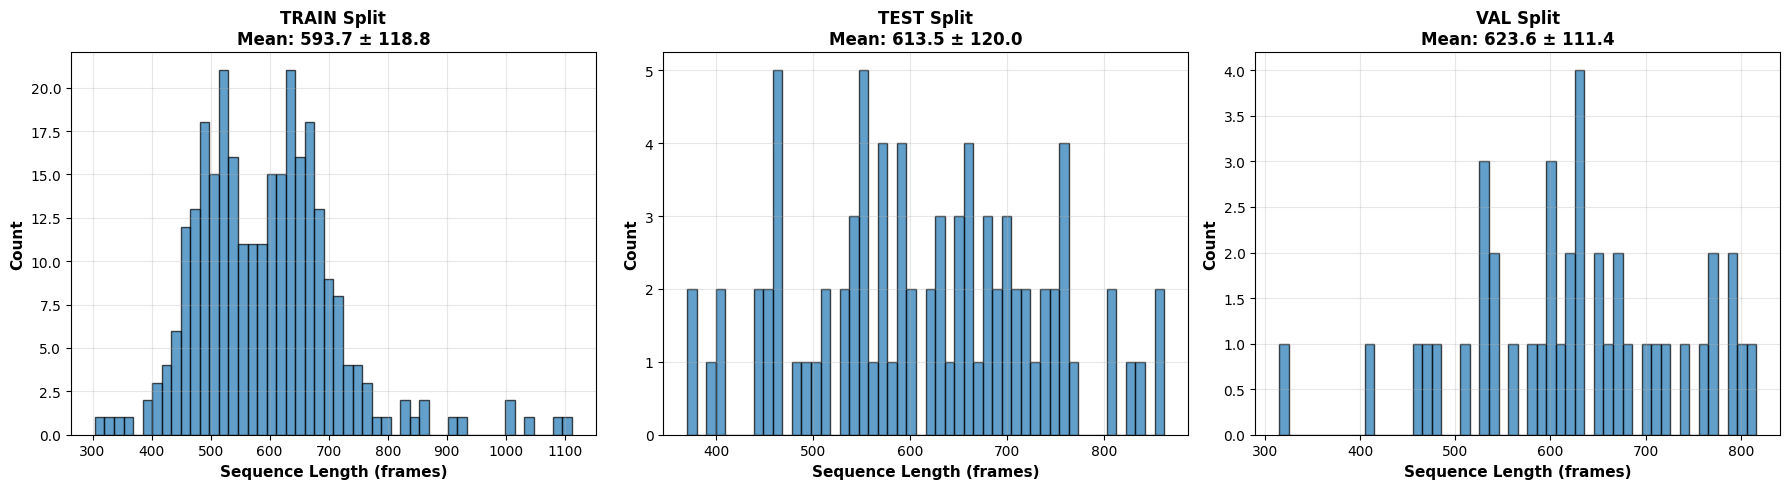


✅ Saved: eda_sequence_lengths.png

FEATURE DISTRIBUTION ANALYSIS


Loading train samples: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]



pos_x:
   Mean: 0.5127
   Std: 0.5631
   Min: -0.4056
   Max: 2.4065
   5th percentile: -0.0798
   95th percentile: 1.6139

pos_y:
   Mean: -0.2665
   Std: 0.2510
   Min: -1.4813
   Max: 0.7686
   5th percentile: -0.6951
   95th percentile: 0.1156

pos_z:
   Mean: 0.9568
   Std: 0.4173
   Min: -0.0634
   Max: 2.0415
   5th percentile: 0.0763
   95th percentile: 1.5126

vel_x:
   Mean: -2.9915
   Std: 196.7517
   Min: -10880.6270
   Max: 4143.7134
   5th percentile: -283.7310
   95th percentile: 274.0827

vel_y:
   Mean: 2.4975
   Std: 117.5510
   Min: -4340.1733
   Max: 4548.7646
   5th percentile: -138.0928
   95th percentile: 158.2833

vel_z:
   Mean: 12.1647
   Std: 228.6599
   Min: -3005.5935
   Max: 5223.5591
   5th percentile: -136.5369
   95th percentile: 216.4337

ang_x:
   Mean: 21.1956
   Std: 52.6441
   Min: -198.3519
   Max: 190.9710
   5th percentile: -72.6353
   95th percentile: 111.5882

ang_y:
   Mean: 4.6826
   Std: 21.6219
   Min: -78.8471
   Max: 141.8445
   5th per

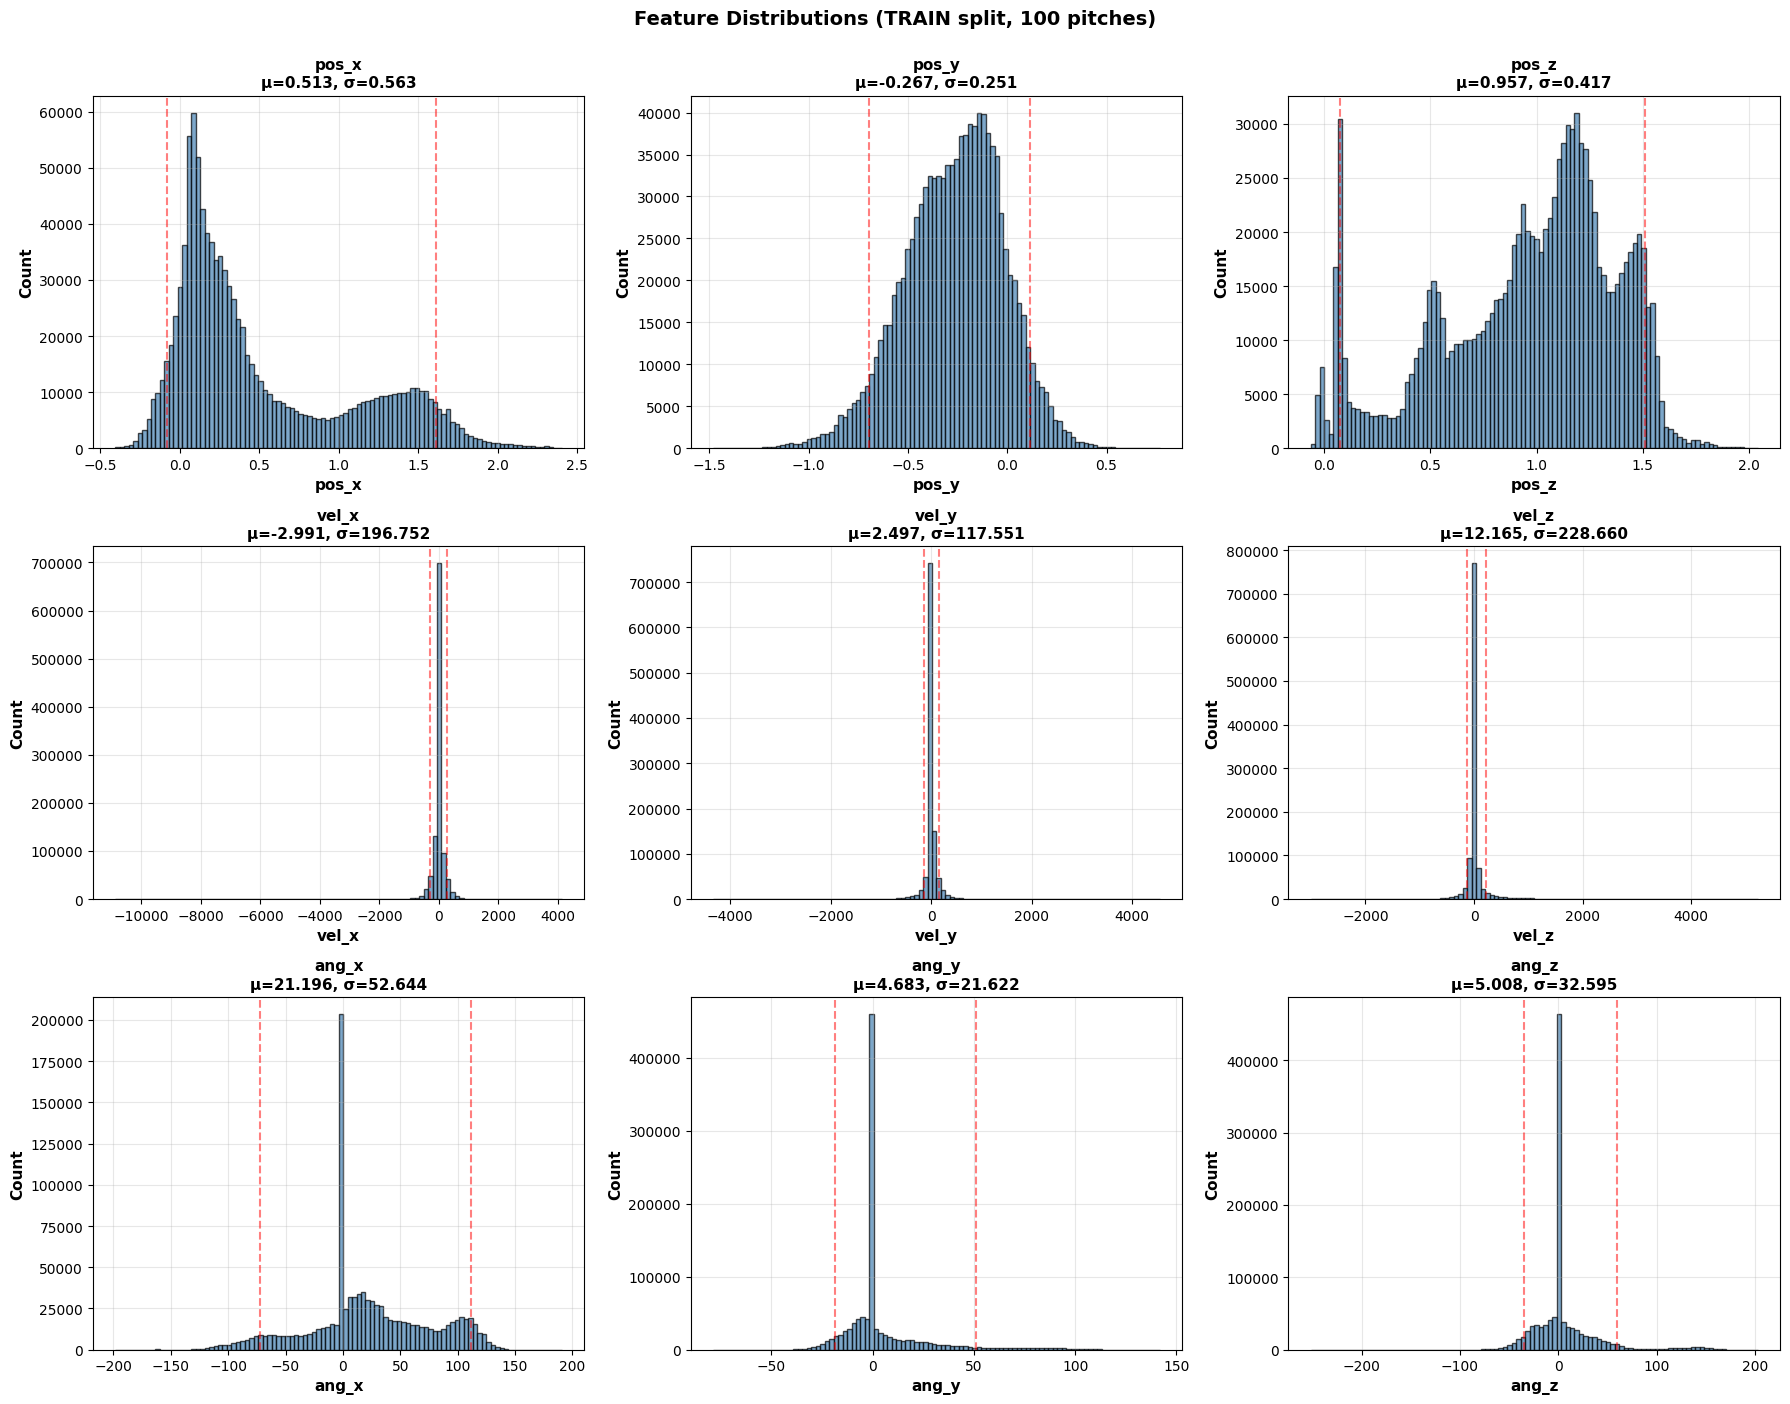


✅ Saved: eda_feature_distributions_train.png

PER-JOINT STATISTICS


Analyzing joints: 100%|██████████| 100/100 [00:22<00:00,  4.53it/s]



Joint Position Statistics (mean ± std):
            joint  pos_x_mean  pos_y_mean  pos_z_mean
     centerofmass    0.528776   -0.250421    0.975550
         elbow_jc    0.337827   -0.178209    1.096179
   glove_elbow_jc    0.684541   -0.297521    1.132153
    glove_hand_jc    0.603690   -0.372523    1.132474
glove_shoulder_jc    0.617539   -0.232900    1.320673
   glove_wrist_jc    0.618304   -0.351124    1.126738
          hand_jc    0.365846   -0.262739    1.126637
    lead_ankle_jc    0.752934   -0.368964    0.238436
         lead_hip    0.651319   -0.220791    0.844931
     lead_knee_jc    0.675780   -0.360448    0.644219
    rear_ankle_jc    0.213351   -0.266506    0.141753
         rear_hip    0.477670   -0.218476    0.814226
     rear_knee_jc    0.356337   -0.335672    0.456675
      shoulder_jc    0.432254   -0.187810    1.298940
        thorax_ap    0.479632   -0.212187    1.322701
      thorax_dist    0.548950   -0.215973    1.105693
      thorax_prox    0.522248   -0.218501

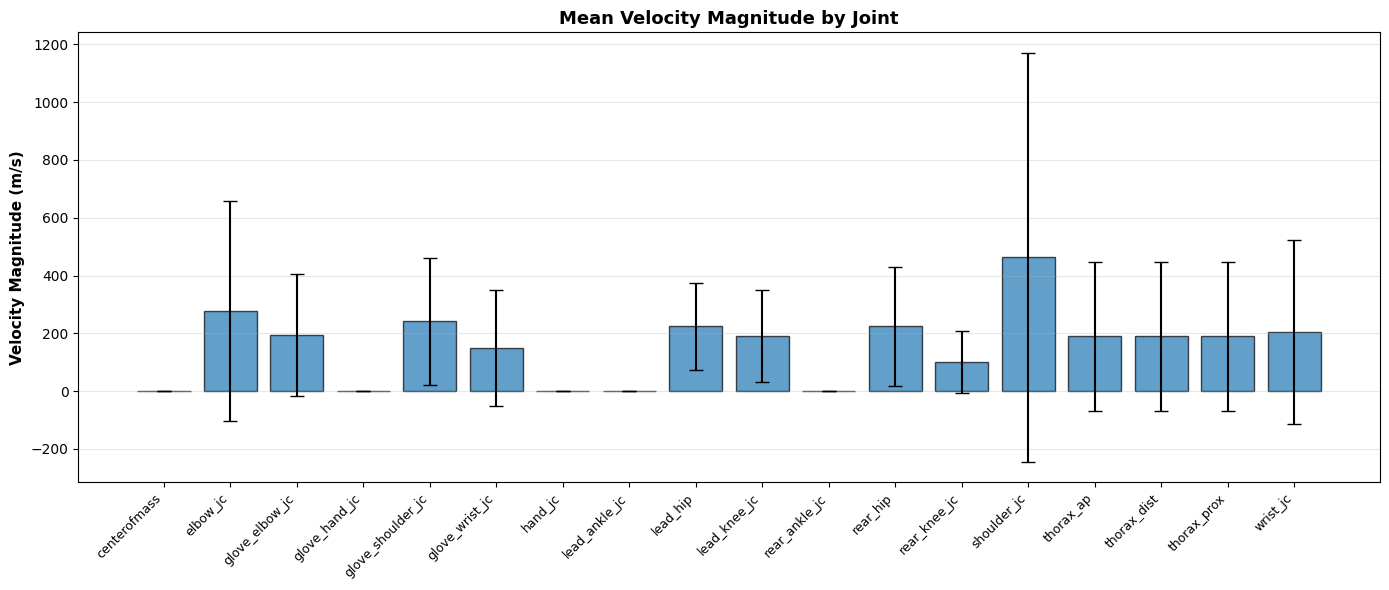


✅ Saved: eda_joint_velocities_train.png

TEMPORAL PATTERN ANALYSIS


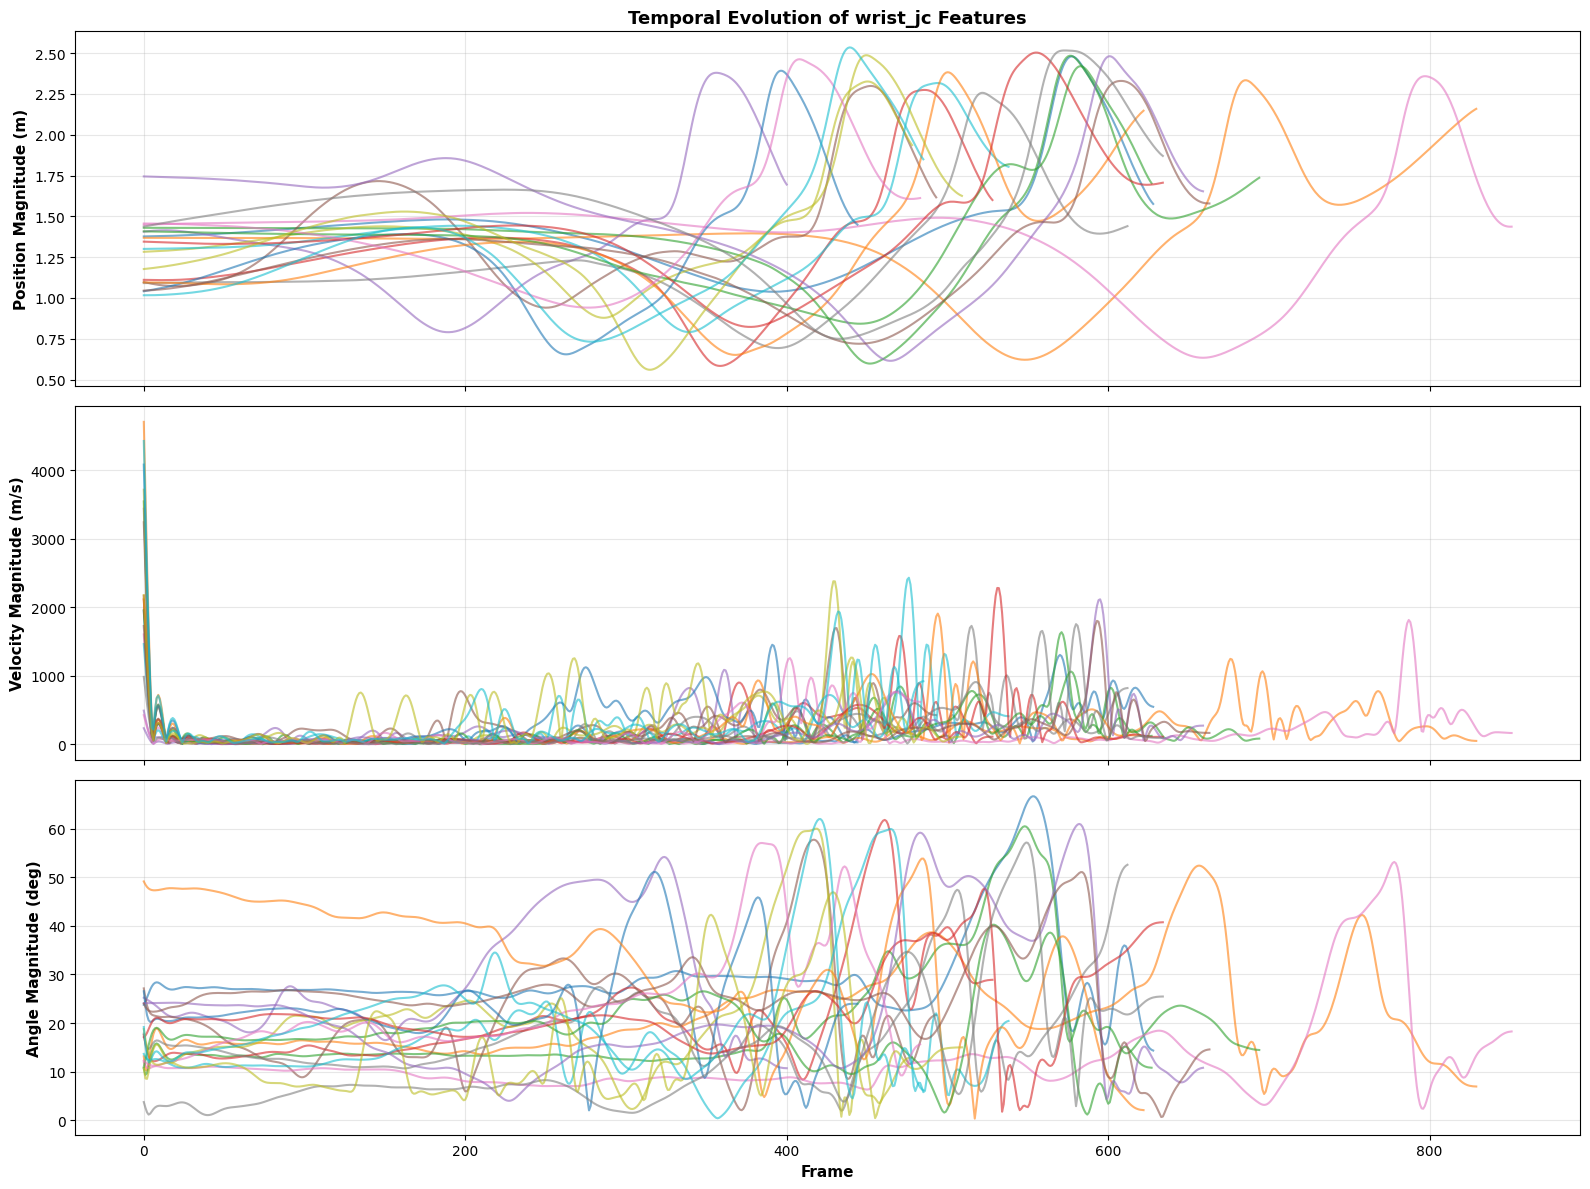


✅ Saved: eda_temporal_patterns_train.png

GLOBAL FEATURE ANALYSIS


Loading global features: 100%|██████████| 287/287 [00:44<00:00,  6.44it/s]


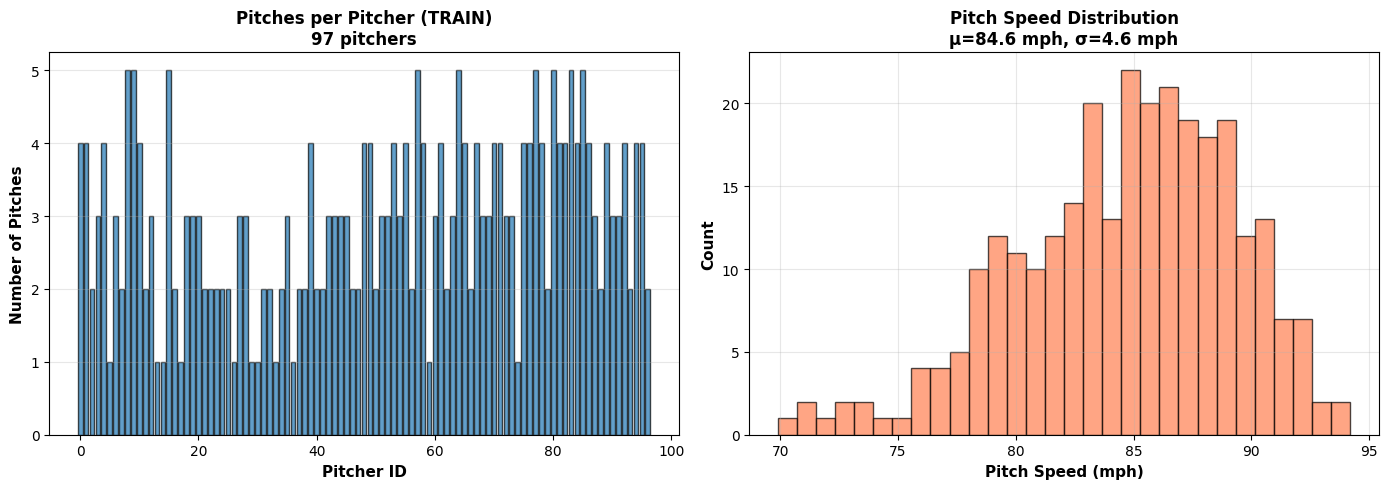


✅ Saved: eda_global_features_train.png

Pitch Speed Statistics:
   Mean: 84.63 mph
   Std: 4.62 mph
   Min: 69.90 mph
   Max: 94.20 mph

Pitcher Distribution:
   Total pitchers: 97
   Mean pitches per pitcher: 2.96
   Min pitches per pitcher: 1
   Max pitches per pitcher: 5

DATA QUALITY CHECK


Checking data quality: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


Data Quality Report (train split, 100 pitches):
   Total values: 19,314,288
   NaN values: 0 (0.0000%)
   Inf values: 0 (0.0000%)
   ✅ No data quality issues found!

✅ FULL EDA COMPLETE!

📊 All EDA plots saved to: /project/vil_baek/psaap/baseball/seq_baseball_data_fixed


In [21]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

class BaseballDataEDA:
    """
    Exploratory Data Analysis for processed baseball pitching PyG dataset.
    """
    
    def __init__(self, data_dir: Path):
        self.data_dir = Path(data_dir)
        
        # Load metadata
        with open(self.data_dir / 'dataset_info.json', 'r') as f:
            self.dataset_info = json.load(f)
        
        with open(self.data_dir / 'player_mapping.json', 'r') as f:
            self.player_mapping = json.load(f)
        
        with open(self.data_dir / 'data_splits.json', 'r') as f:
            self.splits = json.load(f)
        
        print("=" * 70)
        print("BASEBALL PITCHING DATASET - EDA")
        print("=" * 70)
        print(f"\n📊 Dataset Overview:")
        print(f"   Total pitches: {self.dataset_info['total_pitches']}")
        print(f"   Processed pitches: {self.dataset_info['processed_pitches']}")
        print(f"   Number of joints: {self.dataset_info['num_joints']}")
        print(f"   Features per joint: {self.dataset_info['feature_dim']}")
        print(f"   Data format: {self.dataset_info['data_format']}")
        print(f"\n   Train: {len(self.splits['train'])} pitches")
        print(f"   Test:  {len(self.splits['test'])} pitches")
        print(f"   Val:   {len(self.splits['val'])} pitches")
        print(f"\n   Number of pitchers: {len(self.player_mapping)}")
    
    def load_sample_pitches(self, split='train', n_samples=10):
        """Load a sample of pitches from a split"""
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))[:n_samples]
        
        pitches = []
        for pitch_file in pitch_files:
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            pitches.append({
                'file': pitch_file.stem,
                'sequence': pitch_sequence,
                'num_frames': len(pitch_sequence)
            })
        
        return pitches
    
    def analyze_sequence_lengths(self):
        """Analyze the distribution of sequence lengths across all splits"""
        print("\n" + "=" * 70)
        print("SEQUENCE LENGTH ANALYSIS")
        print("=" * 70)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for idx, split in enumerate(['train', 'test', 'val']):
            split_dir = self.data_dir / split
            pitch_files = list(split_dir.glob('*.pt'))
            
            sequence_lengths = []
            for pitch_file in tqdm(pitch_files, desc=f"Analyzing {split}", leave=False):
                pitch_sequence = torch.load(pitch_file, weights_only=False)
                sequence_lengths.append(len(pitch_sequence))
            
            ax = axes[idx]
            ax.hist(sequence_lengths, bins=50, edgecolor='black', alpha=0.7)
            ax.set_xlabel('Sequence Length (frames)', fontsize=11, fontweight='bold')
            ax.set_ylabel('Count', fontsize=11, fontweight='bold')
            ax.set_title(f'{split.upper()} Split\nMean: {np.mean(sequence_lengths):.1f} ± {np.std(sequence_lengths):.1f}', 
                        fontsize=12, fontweight='bold')
            ax.grid(alpha=0.3)
            
            print(f"\n{split.upper()} Split Statistics:")
            print(f"   Total pitches: {len(sequence_lengths)}")
            print(f"   Mean length: {np.mean(sequence_lengths):.2f} frames")
            print(f"   Std length: {np.std(sequence_lengths):.2f} frames")
            print(f"   Min length: {np.min(sequence_lengths)} frames")
            print(f"   Max length: {np.max(sequence_lengths)} frames")
            print(f"   Median length: {np.median(sequence_lengths):.2f} frames")
        
        plt.tight_layout()
        plt.savefig(self.data_dir / 'eda_sequence_lengths.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved: eda_sequence_lengths.png")
    
    def analyze_feature_distributions(self, split='train', n_samples=100):
        """Analyze the distribution of features across joints and time"""
        print("\n" + "=" * 70)
        print("FEATURE DISTRIBUTION ANALYSIS")
        print("=" * 70)
        
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))[:n_samples]
        
        # Collect all features
        all_x_features = []
        all_y_features = []
        
        for pitch_file in tqdm(pitch_files, desc=f"Loading {split} samples"):
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            for data in pitch_sequence:
                all_x_features.append(data.x.numpy())
                all_y_features.append(data.y.numpy())
        
        all_x_features = np.concatenate(all_x_features, axis=0)  # (total_joints, 9)
        all_y_features = np.concatenate(all_y_features, axis=0)  # (total_joints, 9)
        
        # Feature names
        feature_names = ['pos_x', 'pos_y', 'pos_z', 
                        'vel_x', 'vel_y', 'vel_z',
                        'ang_x', 'ang_y', 'ang_z']
        
        # Plot distributions
        fig, axes = plt.subplots(3, 3, figsize=(18, 14))
        axes = axes.flatten()
        
        for i, (ax, feat_name) in enumerate(zip(axes, feature_names)):
            feature_data = all_x_features[:, i]
            
            ax.hist(feature_data, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
            ax.set_xlabel(feat_name, fontsize=11, fontweight='bold')
            ax.set_ylabel('Count', fontsize=11, fontweight='bold')
            ax.set_title(f'{feat_name}\nμ={np.mean(feature_data):.3f}, σ={np.std(feature_data):.3f}',
                        fontsize=11, fontweight='bold')
            ax.grid(alpha=0.3)
            
            # Add percentile lines
            p5, p95 = np.percentile(feature_data, [5, 95])
            ax.axvline(p5, color='red', linestyle='--', alpha=0.5, label='5th %ile')
            ax.axvline(p95, color='red', linestyle='--', alpha=0.5, label='95th %ile')
            
            print(f"\n{feat_name}:")
            print(f"   Mean: {np.mean(feature_data):.4f}")
            print(f"   Std: {np.std(feature_data):.4f}")
            print(f"   Min: {np.min(feature_data):.4f}")
            print(f"   Max: {np.max(feature_data):.4f}")
            print(f"   5th percentile: {p5:.4f}")
            print(f"   95th percentile: {p95:.4f}")
        
        plt.suptitle(f'Feature Distributions ({split.upper()} split, {n_samples} pitches)', 
                    fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.savefig(self.data_dir / f'eda_feature_distributions_{split}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved: eda_feature_distributions_{split}.png")
    
    def analyze_joint_statistics(self, split='train', n_samples=100):
        """Analyze statistics per joint"""
        print("\n" + "=" * 70)
        print("PER-JOINT STATISTICS")
        print("=" * 70)
        
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))[:n_samples]
        
        joint_names = self.dataset_info['joint_names']
        num_joints = len(joint_names)
        
        # Collect features per joint
        joint_features = defaultdict(list)
        
        for pitch_file in tqdm(pitch_files, desc=f"Analyzing joints"):
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            for data in pitch_sequence:
                for j in range(num_joints):
                    joint_features[j].append(data.x[j].numpy())
        
        # Compute statistics per joint
        joint_stats = []
        for j in range(num_joints):
            features = np.array(joint_features[j])  # (num_samples, 9)
            joint_stats.append({
                'joint': joint_names[j],
                'pos_x_mean': np.mean(features[:, 0]),
                'pos_y_mean': np.mean(features[:, 1]),
                'pos_z_mean': np.mean(features[:, 2]),
                'pos_x_std': np.std(features[:, 0]),
                'pos_y_std': np.std(features[:, 1]),
                'pos_z_std': np.std(features[:, 2]),
                'vel_magnitude_mean': np.mean(np.linalg.norm(features[:, 3:6], axis=1)),
                'vel_magnitude_std': np.std(np.linalg.norm(features[:, 3:6], axis=1)),
            })
        
        df_stats = pd.DataFrame(joint_stats)
        
        print(f"\nJoint Position Statistics (mean ± std):")
        print(df_stats[['joint', 'pos_x_mean', 'pos_y_mean', 'pos_z_mean']].to_string(index=False))
        
        print(f"\nJoint Velocity Magnitude Statistics:")
        print(df_stats[['joint', 'vel_magnitude_mean', 'vel_magnitude_std']].to_string(index=False))
        
        # Plot velocity magnitudes by joint
        fig, ax = plt.subplots(figsize=(14, 6))
        x_pos = np.arange(len(joint_names))
        ax.bar(x_pos, df_stats['vel_magnitude_mean'], yerr=df_stats['vel_magnitude_std'],
               capsize=5, alpha=0.7, edgecolor='black')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(joint_names, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Velocity Magnitude (m/s)', fontsize=11, fontweight='bold')
        ax.set_title('Mean Velocity Magnitude by Joint', fontsize=13, fontweight='bold')
        ax.grid(alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(self.data_dir / f'eda_joint_velocities_{split}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved: eda_joint_velocities_{split}.png")
        
        return df_stats
    
    def analyze_temporal_patterns(self, split='train', n_samples=10):
        """Analyze how features evolve over time within pitches"""
        print("\n" + "=" * 70)
        print("TEMPORAL PATTERN ANALYSIS")
        print("=" * 70)
        
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))[:n_samples]
        
        fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
        
        for pitch_file in pitch_files:
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            
            # Extract features over time for a key joint (e.g., wrist or hand)
            # Find index of throwing arm wrist/hand
            joint_names = self.dataset_info['joint_names']
            key_joints = ['wrist_jc', 'hand_jc', 'elbow_jc']
            
            for key_joint in key_joints:
                if key_joint in joint_names:
                    joint_idx = joint_names.index(key_joint)
                    break
            
            positions = []
            velocities = []
            angles = []
            
            for data in pitch_sequence:
                positions.append(data.x[joint_idx, :3].numpy())
                velocities.append(data.x[joint_idx, 3:6].numpy())
                angles.append(data.x[joint_idx, 6:9].numpy())
            
            positions = np.array(positions)
            velocities = np.array(velocities)
            angles = np.array(angles)
            
            time_steps = np.arange(len(positions))
            
            # Plot positions
            axes[0].plot(time_steps, np.linalg.norm(positions, axis=1), alpha=0.6, linewidth=1.5)
            
            # Plot velocities
            axes[1].plot(time_steps, np.linalg.norm(velocities, axis=1), alpha=0.6, linewidth=1.5)
            
            # Plot angles
            axes[2].plot(time_steps, np.linalg.norm(angles, axis=1), alpha=0.6, linewidth=1.5)
        
        axes[0].set_ylabel('Position Magnitude (m)', fontsize=11, fontweight='bold')
        axes[0].set_title(f'Temporal Evolution of {key_joint} Features', fontsize=13, fontweight='bold')
        axes[0].grid(alpha=0.3)
        
        axes[1].set_ylabel('Velocity Magnitude (m/s)', fontsize=11, fontweight='bold')
        axes[1].grid(alpha=0.3)
        
        axes[2].set_ylabel('Angle Magnitude (deg)', fontsize=11, fontweight='bold')
        axes[2].set_xlabel('Frame', fontsize=11, fontweight='bold')
        axes[2].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.data_dir / f'eda_temporal_patterns_{split}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved: eda_temporal_patterns_{split}.png")
    
    def analyze_global_features(self, split='train'):
        """Analyze distribution of global features (pitcher_id, pitch_speed, etc.)"""
        print("\n" + "=" * 70)
        print("GLOBAL FEATURE ANALYSIS")
        print("=" * 70)
        
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))
        
        pitcher_ids = []
        pitch_speeds = []
        
        for pitch_file in tqdm(pitch_files, desc=f"Loading global features"):
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            # Get from first frame (same for whole pitch)
            pitcher_ids.append(pitch_sequence[0].pitcher_id.item())
            pitch_speeds.append(pitch_sequence[0].pitch_speed.item())
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Pitcher distribution
        unique_pitchers, pitcher_counts = np.unique(pitcher_ids, return_counts=True)
        axes[0].bar(range(len(unique_pitchers)), pitcher_counts, edgecolor='black', alpha=0.7)
        axes[0].set_xlabel('Pitcher ID', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('Number of Pitches', fontsize=11, fontweight='bold')
        axes[0].set_title(f'Pitches per Pitcher ({split.upper()})\n{len(unique_pitchers)} pitchers', 
                         fontsize=12, fontweight='bold')
        axes[0].grid(alpha=0.3, axis='y')
        
        # Pitch speed distribution
        axes[1].hist(pitch_speeds, bins=30, edgecolor='black', alpha=0.7, color='coral')
        axes[1].set_xlabel('Pitch Speed (mph)', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
        axes[1].set_title(f'Pitch Speed Distribution\nμ={np.mean(pitch_speeds):.1f} mph, σ={np.std(pitch_speeds):.1f} mph',
                         fontsize=12, fontweight='bold')
        axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.data_dir / f'eda_global_features_{split}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved: eda_global_features_{split}.png")
        
        print(f"\nPitch Speed Statistics:")
        print(f"   Mean: {np.mean(pitch_speeds):.2f} mph")
        print(f"   Std: {np.std(pitch_speeds):.2f} mph")
        print(f"   Min: {np.min(pitch_speeds):.2f} mph")
        print(f"   Max: {np.max(pitch_speeds):.2f} mph")
        
        print(f"\nPitcher Distribution:")
        print(f"   Total pitchers: {len(unique_pitchers)}")
        print(f"   Mean pitches per pitcher: {np.mean(pitcher_counts):.2f}")
        print(f"   Min pitches per pitcher: {np.min(pitcher_counts)}")
        print(f"   Max pitches per pitcher: {np.max(pitcher_counts)}")
    
    def check_data_quality(self, split='train', n_samples=100):
        """Check for NaN, Inf, and other data quality issues"""
        print("\n" + "=" * 70)
        print("DATA QUALITY CHECK")
        print("=" * 70)
        
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))[:n_samples]
        
        nan_count = 0
        inf_count = 0
        total_values = 0
        
        for pitch_file in tqdm(pitch_files, desc="Checking data quality"):
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            for data in pitch_sequence:
                x_data = data.x.numpy()
                y_data = data.y.numpy()
                
                total_values += x_data.size + y_data.size
                nan_count += np.isnan(x_data).sum() + np.isnan(y_data).sum()
                inf_count += np.isinf(x_data).sum() + np.isinf(y_data).sum()
        
        print(f"\nData Quality Report ({split} split, {n_samples} pitches):")
        print(f"   Total values: {total_values:,}")
        print(f"   NaN values: {nan_count} ({nan_count/total_values*100:.4f}%)")
        print(f"   Inf values: {inf_count} ({inf_count/total_values*100:.4f}%)")
        
        if nan_count == 0 and inf_count == 0:
            print("   ✅ No data quality issues found!")
        else:
            print("   ⚠️  Data quality issues detected!")
    
    def run_full_eda(self):
        """Run all EDA analyses"""
        print("\n" + "=" * 70)
        print("RUNNING FULL EDA")
        print("=" * 70)
        
        # 1. Sequence lengths
        self.analyze_sequence_lengths()
        
        # 2. Feature distributions
        self.analyze_feature_distributions(split='train', n_samples=100)
        
        # 3. Joint statistics
        self.analyze_joint_statistics(split='train', n_samples=100)
        
        # 4. Temporal patterns
        self.analyze_temporal_patterns(split='train', n_samples=20)
        
        # 5. Global features
        self.analyze_global_features(split='train')
        
        # 6. Data quality
        self.check_data_quality(split='train', n_samples=100)
        
        print("\n" + "=" * 70)
        print("✅ FULL EDA COMPLETE!")
        print("=" * 70)


# ==================== MAIN EXECUTION ====================

if __name__ == '__main__':
    # Set your data directory
    DATA_DIR = Path("/project/vil_baek/psaap/baseball/seq_baseball_data_fixed")
    
    # Create EDA analyzer
    eda = BaseballDataEDA(DATA_DIR)
    
    # Run full EDA
    eda.run_full_eda()
    
    print(f"\n📊 All EDA plots saved to: {DATA_DIR}")

✅ Loaded normalization statistics
BASEBALL PITCHING DATASET - EDA

📊 Dataset Overview:
   Total pitches: 411
   Processed pitches: 411
   Number of joints: 18
   Features per joint: 9
   Data format: positions_velocities_angles_concatenated
   Normalization applied: True

   Train: 287 pitches
   Test:  83 pitches
   Val:   41 pitches

   Number of pitchers: 100

📐 Normalization Statistics:
   Position mean: [ 0.50086975 -0.26173234  0.96277076]
   Position std:  [0.56000387 0.24239525 0.42110046]
   Velocity mean: [-3.08148002  2.59365509 11.88298218]
   Velocity std:  [196.36776008 116.87075761 229.27858962]
   Angle mean:    [21.08132924  4.73080934  4.70793478]
   Angle std:     [52.40852559 21.66349772 32.01603466]

RUNNING FULL EDA

SEQUENCE LENGTH ANALYSIS



TRAIN Split Statistics:
   Total pitches: 287
   Mean length: 593.73 frames
   Std length: 118.84 frames
   Min length: 304 frames
   Max length: 1112 frames
   Median length: 592.00 frames



TEST Split Statistics:
   Total pitches: 83
   Mean length: 613.46 frames
   Std length: 119.96 frames
   Min length: 370 frames
   Max length: 862 frames
   Median length: 617.00 frames



VAL Split Statistics:
   Total pitches: 41
   Mean length: 623.63 frames
   Std length: 111.43 frames
   Min length: 315 frames
   Max length: 816 frames
   Median length: 626.00 frames


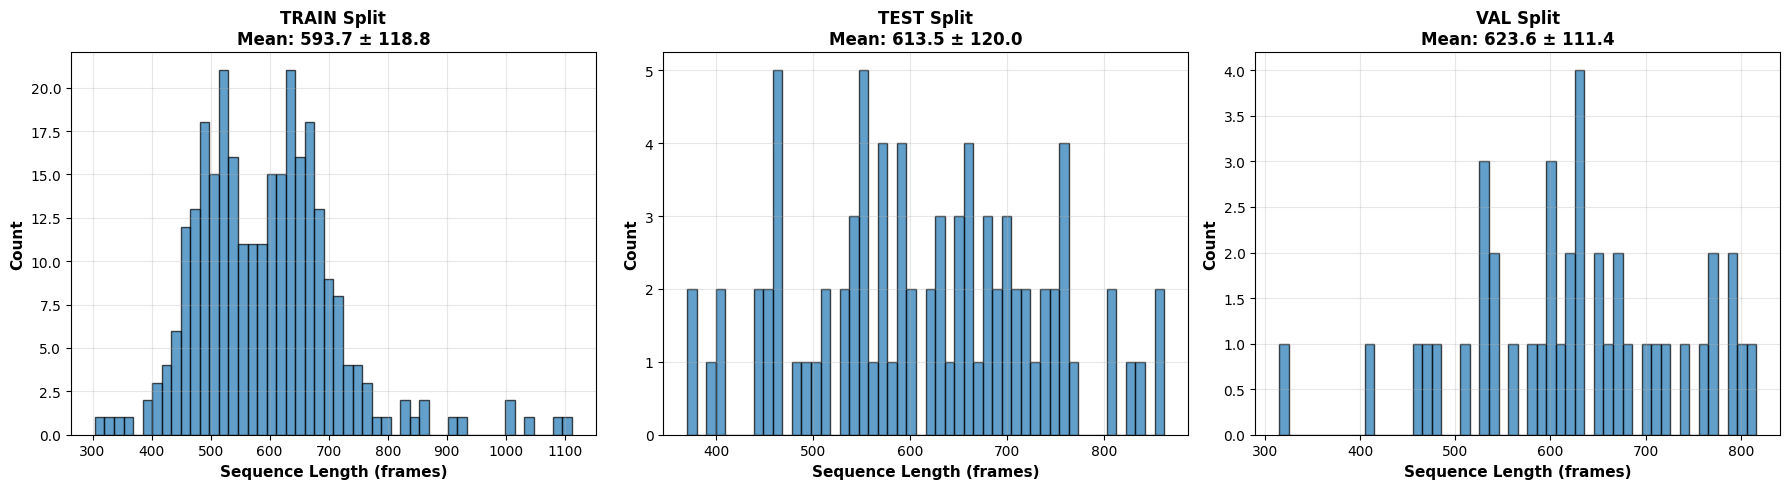


✅ Saved: eda_sequence_lengths.png

FEATURE DISTRIBUTION ANALYSIS
NOTE: Data is NORMALIZED - expect values centered around 0


Loading train samples: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]



pos_x (norm):
   Mean: 0.0211
   Std: 1.0056
   Min: -1.6187
   Max: 3.4029
   5th percentile: -1.0369
   95th percentile: 1.9875

pos_y (norm):
   Mean: -0.0199
   Std: 1.0353
   Min: -5.0313
   Max: 4.2506
   5th percentile: -1.7879
   95th percentile: 1.5567

pos_z (norm):
   Mean: -0.0142
   Std: 0.9910
   Min: -2.4369
   Max: 2.5617
   5th percentile: -2.1051
   95th percentile: 1.3057

vel_x (norm):
   Mean: 0.0005
   Std: 1.0020
   Min: -55.3937
   Max: 21.1175
   5th percentile: -1.4292
   95th percentile: 1.4115

vel_y (norm):
   Mean: -0.0008
   Std: 1.0058
   Min: -37.1587
   Max: 38.8991
   5th percentile: -1.2038
   95th percentile: 1.3322

vel_z (norm):
   Mean: 0.0012
   Std: 0.9973
   Min: -13.1607
   Max: 22.7308
   5th percentile: -0.6473
   95th percentile: 0.8921

ang_x (norm):
   Mean: 0.0022
   Std: 1.0045
   Min: -4.1870
   Max: 3.2416
   5th percentile: -1.7882
   95th percentile: 1.7270

ang_y (norm):
   Mean: -0.0022
   Std: 0.9981
   Min: -3.8580
   Max: 6.3

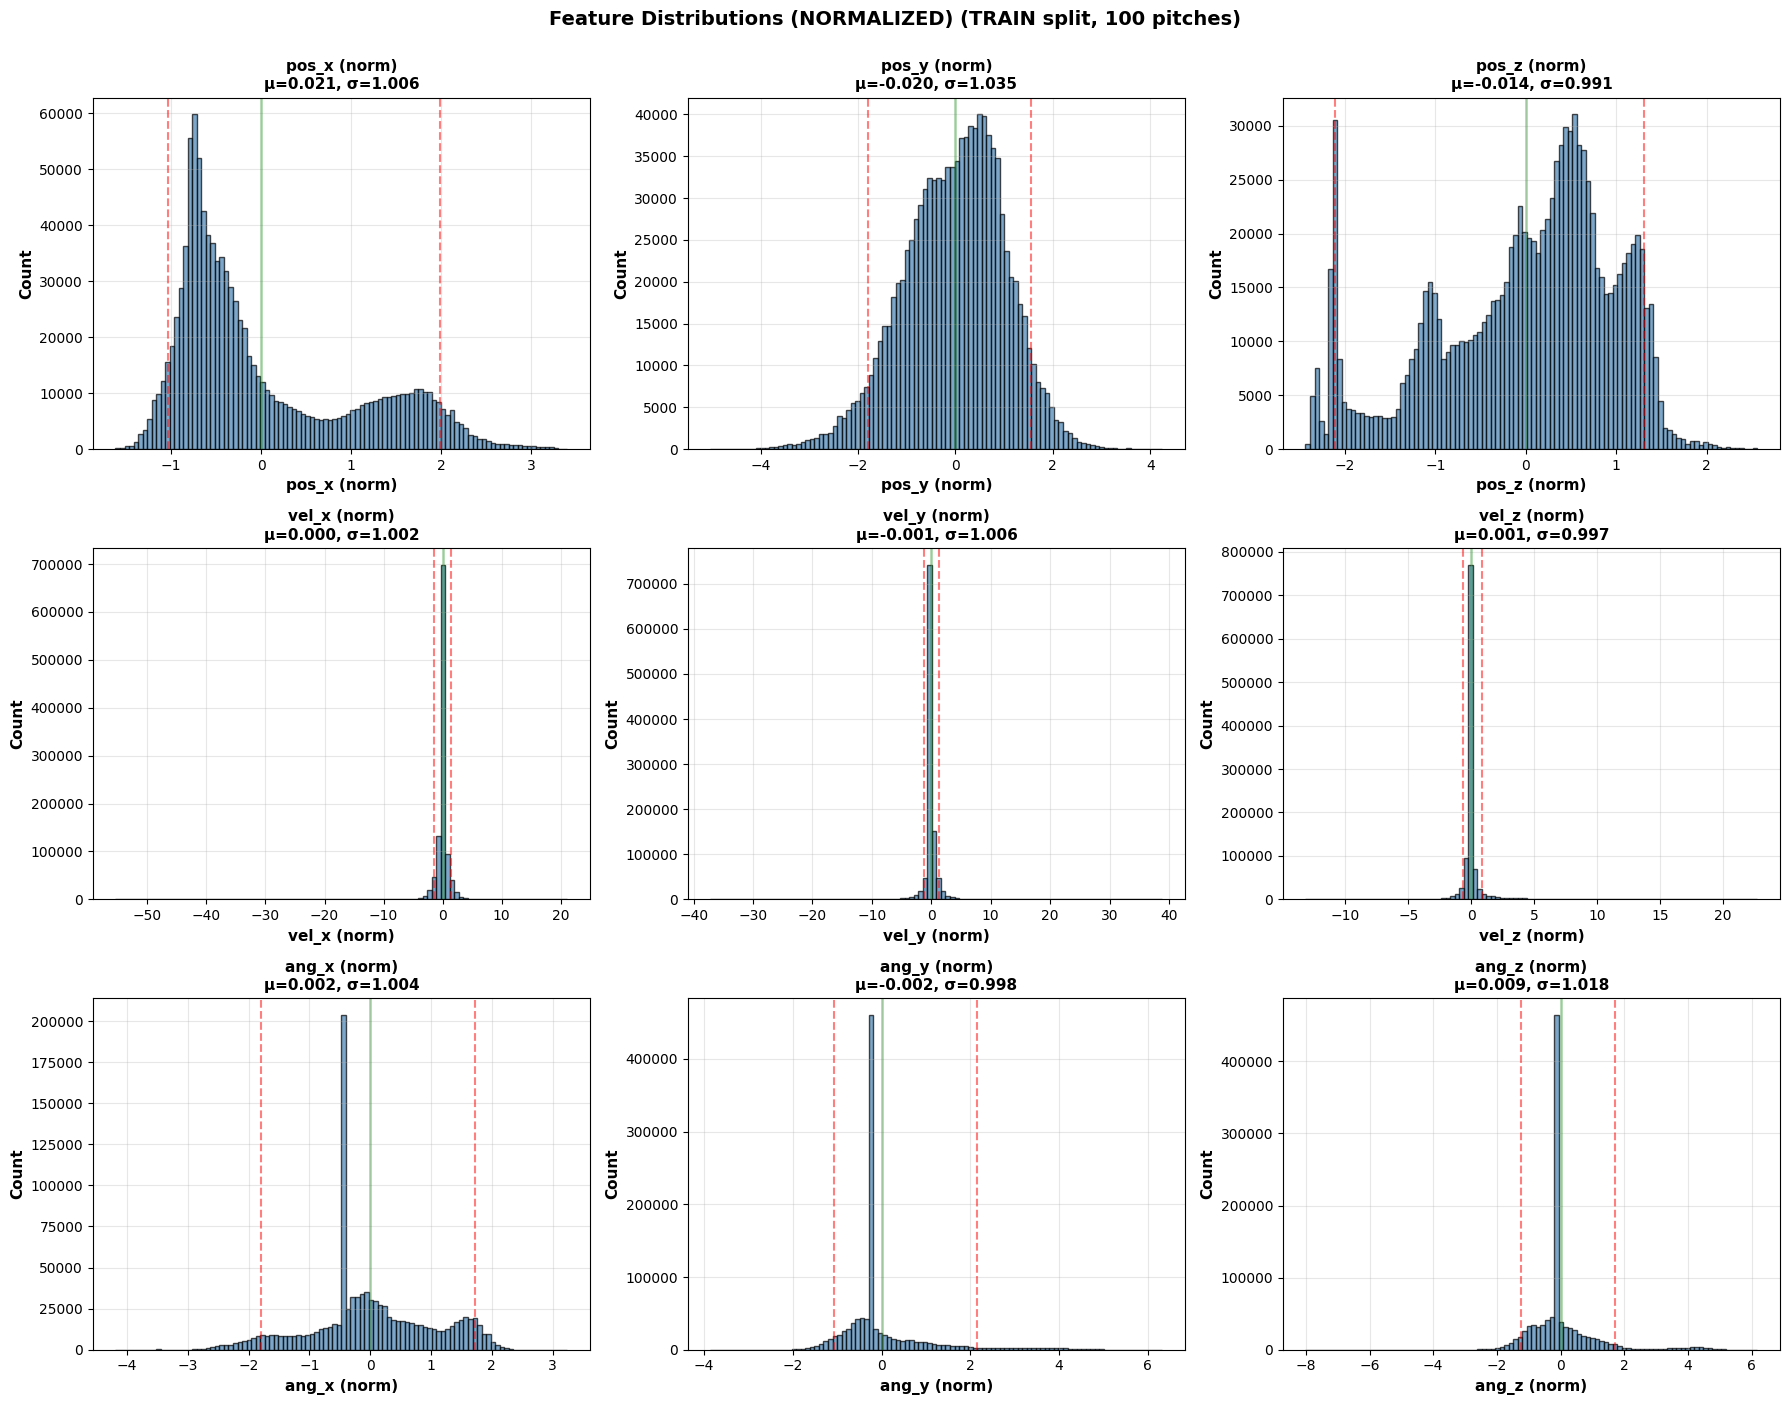


✅ Saved: eda_feature_distributions_train.png

PER-JOINT STATISTICS


Analyzing joints: 100%|██████████| 100/100 [00:21<00:00,  4.60it/s]



Joint Position Statistics (mean ± std):
            joint  pos_x_mean  pos_y_mean  pos_z_mean
     centerofmass    0.049831    0.046665    0.030347
         elbow_jc   -0.291147    0.344576    0.316809
   glove_elbow_jc    0.327982   -0.147645    0.402238
    glove_hand_jc    0.183606   -0.457068    0.403000
glove_shoulder_jc    0.208336    0.118947    0.849922
   glove_wrist_jc    0.209702   -0.368785    0.389377
          hand_jc   -0.241112   -0.004152    0.389138
    lead_ankle_jc    0.450112   -0.442384   -1.720101
         lead_hip    0.268658    0.168903   -0.279839
     lead_knee_jc    0.312337   -0.407252   -0.756473
    rear_ankle_jc   -0.513424   -0.019695   -1.949695
         rear_hip   -0.041428    0.178455   -0.352754
     rear_knee_jc   -0.258092   -0.305037   -1.201841
      shoulder_jc   -0.122528    0.304967    0.798310
        thorax_ap   -0.037924    0.204399    0.854736
      thorax_dist    0.085857    0.188779    0.339402
      thorax_prox    0.038176    0.178351

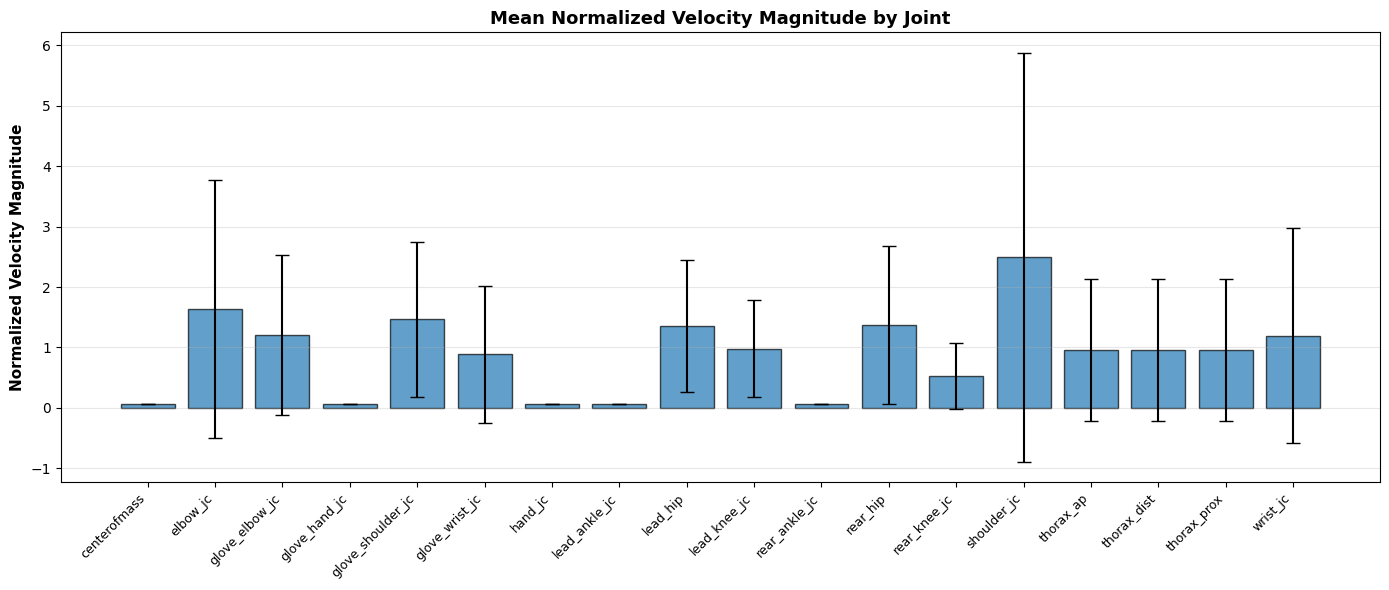


✅ Saved: eda_joint_velocities_train.png

TEMPORAL PATTERN ANALYSIS


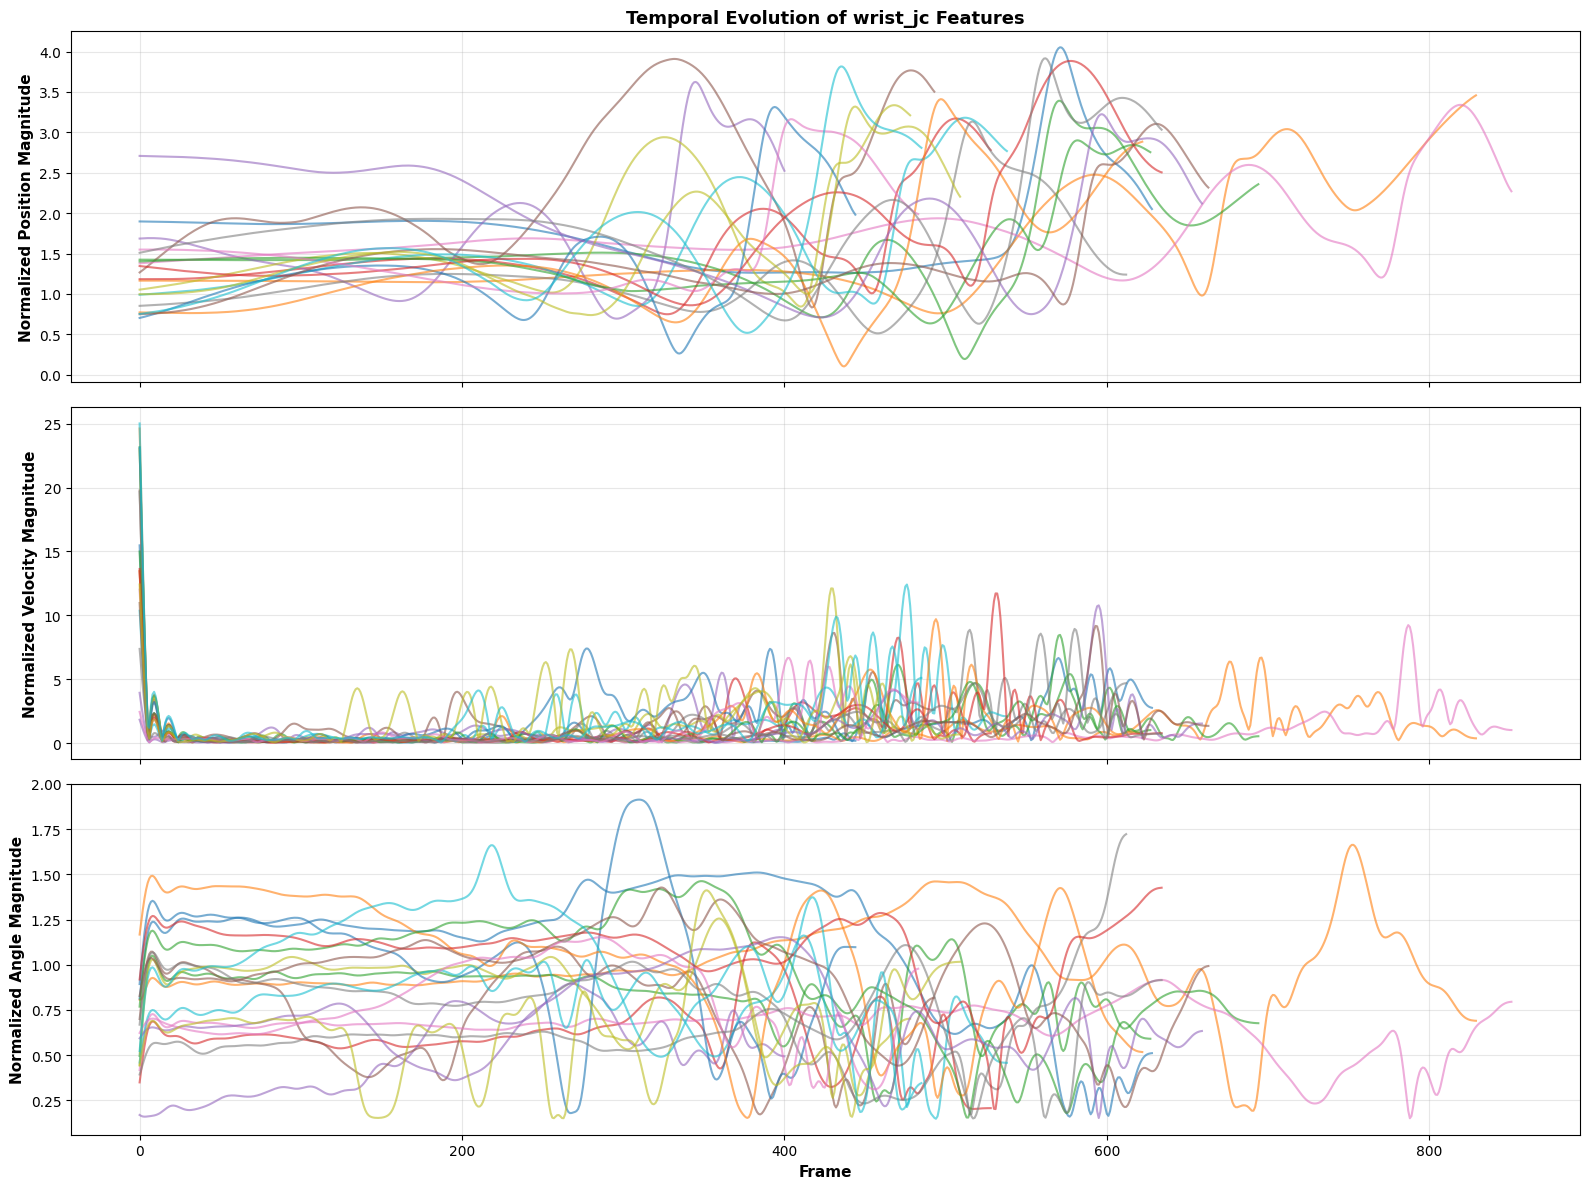


✅ Saved: eda_temporal_patterns_train.png

GLOBAL FEATURE ANALYSIS


Loading global features: 100%|██████████| 287/287 [00:44<00:00,  6.42it/s]


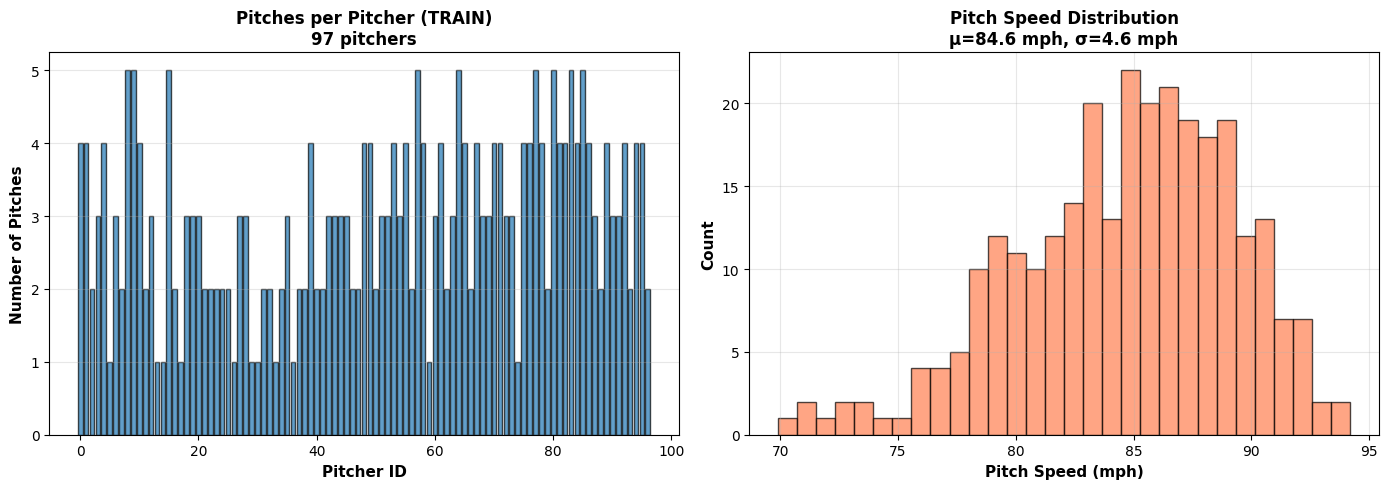


✅ Saved: eda_global_features_train.png

Pitch Speed Statistics:
   Mean: 84.63 mph
   Std: 4.62 mph
   Min: 69.90 mph
   Max: 94.20 mph

Pitcher Distribution:
   Total pitchers: 97
   Mean pitches per pitcher: 2.96
   Min pitches per pitcher: 1
   Max pitches per pitcher: 5

DATA QUALITY CHECK


Checking data quality: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]



Data Quality Report (train split, 100 pitches):
   Total values: 19,314,288
   NaN values: 0 (0.0000%)
   Inf values: 0 (0.0000%)
   ✅ No data quality issues found!

📊 Normalization Quality Check:
   Overall mean: -0.0094 (should be close to 0)
   Average std: 0.9801 (should be close to 1)
   ✅ Normalization looks good!

✅ FULL EDA COMPLETE!

📊 All EDA plots saved to: /project/vil_baek/psaap/baseball/seq_baseball_data_normalized


In [26]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import pickle

class BaseballDataEDA:
    """
    Exploratory Data Analysis for processed baseball pitching PyG dataset.
    Updated to handle normalized data.
    """
    
    def __init__(self, data_dir: Path):
        self.data_dir = Path(data_dir)
        
        # Load metadata
        with open(self.data_dir / 'dataset_info.json', 'r') as f:
            self.dataset_info = json.load(f)
        
        with open(self.data_dir / 'player_mapping.json', 'r') as f:
            self.player_mapping = json.load(f)
        
        with open(self.data_dir / 'data_splits.json', 'r') as f:
            self.splits = json.load(f)
        
        # Load normalization stats if they exist
        norm_stats_path = self.data_dir / 'normalization_stats.pkl'
        if norm_stats_path.exists():
            with open(norm_stats_path, 'rb') as f:
                self.normalization_stats = pickle.load(f)
            print("✅ Loaded normalization statistics")
        else:
            self.normalization_stats = None
            print("⚠️  No normalization statistics found")
        
        print("=" * 70)
        print("BASEBALL PITCHING DATASET - EDA")
        print("=" * 70)
        print(f"\n📊 Dataset Overview:")
        print(f"   Total pitches: {self.dataset_info['total_pitches']}")
        print(f"   Processed pitches: {self.dataset_info['processed_pitches']}")
        print(f"   Number of joints: {self.dataset_info['num_joints']}")
        print(f"   Features per joint: {self.dataset_info['feature_dim']}")
        print(f"   Data format: {self.dataset_info['data_format']}")
        print(f"   Normalization applied: {self.dataset_info['normalization_applied']}")
        print(f"\n   Train: {len(self.splits['train'])} pitches")
        print(f"   Test:  {len(self.splits['test'])} pitches")
        print(f"   Val:   {len(self.splits['val'])} pitches")
        print(f"\n   Number of pitchers: {len(self.player_mapping)}")
        
        if self.normalization_stats:
            print(f"\n📐 Normalization Statistics:")
            print(f"   Position mean: {self.normalization_stats['position_mean']}")
            print(f"   Position std:  {self.normalization_stats['position_std']}")
            print(f"   Velocity mean: {self.normalization_stats['velocity_mean']}")
            print(f"   Velocity std:  {self.normalization_stats['velocity_std']}")
            print(f"   Angle mean:    {self.normalization_stats['angle_mean']}")
            print(f"   Angle std:     {self.normalization_stats['angle_std']}")
    
    def load_sample_pitches(self, split='train', n_samples=10):
        """Load a sample of pitches from a split"""
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))[:n_samples]
        
        pitches = []
        for pitch_file in pitch_files:
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            pitches.append({
                'file': pitch_file.stem,
                'sequence': pitch_sequence,
                'num_frames': len(pitch_sequence)
            })
        
        return pitches
    
    def analyze_sequence_lengths(self):
        """Analyze the distribution of sequence lengths across all splits"""
        print("\n" + "=" * 70)
        print("SEQUENCE LENGTH ANALYSIS")
        print("=" * 70)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for idx, split in enumerate(['train', 'test', 'val']):
            split_dir = self.data_dir / split
            pitch_files = list(split_dir.glob('*.pt'))
            
            sequence_lengths = []
            for pitch_file in tqdm(pitch_files, desc=f"Analyzing {split}", leave=False):
                pitch_sequence = torch.load(pitch_file, weights_only=False)
                sequence_lengths.append(len(pitch_sequence))
            
            ax = axes[idx]
            ax.hist(sequence_lengths, bins=50, edgecolor='black', alpha=0.7)
            ax.set_xlabel('Sequence Length (frames)', fontsize=11, fontweight='bold')
            ax.set_ylabel('Count', fontsize=11, fontweight='bold')
            ax.set_title(f'{split.upper()} Split\nMean: {np.mean(sequence_lengths):.1f} ± {np.std(sequence_lengths):.1f}', 
                        fontsize=12, fontweight='bold')
            ax.grid(alpha=0.3)
            
            print(f"\n{split.upper()} Split Statistics:")
            print(f"   Total pitches: {len(sequence_lengths)}")
            print(f"   Mean length: {np.mean(sequence_lengths):.2f} frames")
            print(f"   Std length: {np.std(sequence_lengths):.2f} frames")
            print(f"   Min length: {np.min(sequence_lengths)} frames")
            print(f"   Max length: {np.max(sequence_lengths)} frames")
            print(f"   Median length: {np.median(sequence_lengths):.2f} frames")
        
        plt.tight_layout()
        plt.savefig(self.data_dir / 'eda_sequence_lengths.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved: eda_sequence_lengths.png")
    
    def analyze_feature_distributions(self, split='train', n_samples=100):
        """Analyze the distribution of features across joints and time"""
        print("\n" + "=" * 70)
        print("FEATURE DISTRIBUTION ANALYSIS")
        if self.dataset_info['normalization_applied']:
            print("NOTE: Data is NORMALIZED - expect values centered around 0")
        print("=" * 70)
        
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))[:n_samples]
        
        # Collect all features
        all_x_features = []
        all_y_features = []
        
        for pitch_file in tqdm(pitch_files, desc=f"Loading {split} samples"):
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            for data in pitch_sequence:
                all_x_features.append(data.x.numpy())
                all_y_features.append(data.y.numpy())
        
        all_x_features = np.concatenate(all_x_features, axis=0)  # (total_joints, 9)
        all_y_features = np.concatenate(all_y_features, axis=0)  # (total_joints, 9)
        
        # Feature names
        if self.dataset_info['normalization_applied']:
            feature_names = ['pos_x (norm)', 'pos_y (norm)', 'pos_z (norm)', 
                            'vel_x (norm)', 'vel_y (norm)', 'vel_z (norm)',
                            'ang_x (norm)', 'ang_y (norm)', 'ang_z (norm)']
        else:
            feature_names = ['pos_x', 'pos_y', 'pos_z', 
                            'vel_x', 'vel_y', 'vel_z',
                            'ang_x', 'ang_y', 'ang_z']
        
        # Plot distributions
        fig, axes = plt.subplots(3, 3, figsize=(18, 14))
        axes = axes.flatten()
        
        for i, (ax, feat_name) in enumerate(zip(axes, feature_names)):
            feature_data = all_x_features[:, i]
            
            ax.hist(feature_data, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
            ax.set_xlabel(feat_name, fontsize=11, fontweight='bold')
            ax.set_ylabel('Count', fontsize=11, fontweight='bold')
            ax.set_title(f'{feat_name}\nμ={np.mean(feature_data):.3f}, σ={np.std(feature_data):.3f}',
                        fontsize=11, fontweight='bold')
            ax.grid(alpha=0.3)
            
            # Add percentile lines
            p5, p95 = np.percentile(feature_data, [5, 95])
            ax.axvline(p5, color='red', linestyle='--', alpha=0.5, label='5th %ile')
            ax.axvline(p95, color='red', linestyle='--', alpha=0.5, label='95th %ile')
            
            # Add vertical line at 0 for normalized data
            if self.dataset_info['normalization_applied']:
                ax.axvline(0, color='green', linestyle='-', alpha=0.3, linewidth=2, label='zero')
            
            print(f"\n{feat_name}:")
            print(f"   Mean: {np.mean(feature_data):.4f}")
            print(f"   Std: {np.std(feature_data):.4f}")
            print(f"   Min: {np.min(feature_data):.4f}")
            print(f"   Max: {np.max(feature_data):.4f}")
            print(f"   5th percentile: {p5:.4f}")
            print(f"   95th percentile: {p95:.4f}")
        
        title_suffix = "(NORMALIZED)" if self.dataset_info['normalization_applied'] else "(RAW)"
        plt.suptitle(f'Feature Distributions {title_suffix} ({split.upper()} split, {n_samples} pitches)', 
                    fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.savefig(self.data_dir / f'eda_feature_distributions_{split}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved: eda_feature_distributions_{split}.png")
    
    def analyze_joint_statistics(self, split='train', n_samples=100):
        """Analyze statistics per joint"""
        print("\n" + "=" * 70)
        print("PER-JOINT STATISTICS")
        print("=" * 70)
        
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))[:n_samples]
        
        joint_names = self.dataset_info['joint_names']
        num_joints = len(joint_names)
        
        # Collect features per joint
        joint_features = defaultdict(list)
        
        for pitch_file in tqdm(pitch_files, desc=f"Analyzing joints"):
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            for data in pitch_sequence:
                for j in range(num_joints):
                    joint_features[j].append(data.x[j].numpy())
        
        # Compute statistics per joint
        joint_stats = []
        for j in range(num_joints):
            features = np.array(joint_features[j])  # (num_samples, 9)
            joint_stats.append({
                'joint': joint_names[j],
                'pos_x_mean': np.mean(features[:, 0]),
                'pos_y_mean': np.mean(features[:, 1]),
                'pos_z_mean': np.mean(features[:, 2]),
                'pos_x_std': np.std(features[:, 0]),
                'pos_y_std': np.std(features[:, 1]),
                'pos_z_std': np.std(features[:, 2]),
                'vel_magnitude_mean': np.mean(np.linalg.norm(features[:, 3:6], axis=1)),
                'vel_magnitude_std': np.std(np.linalg.norm(features[:, 3:6], axis=1)),
            })
        
        df_stats = pd.DataFrame(joint_stats)
        
        print(f"\nJoint Position Statistics (mean ± std):")
        print(df_stats[['joint', 'pos_x_mean', 'pos_y_mean', 'pos_z_mean']].to_string(index=False))
        
        print(f"\nJoint Velocity Magnitude Statistics:")
        print(df_stats[['joint', 'vel_magnitude_mean', 'vel_magnitude_std']].to_string(index=False))
        
        # Plot velocity magnitudes by joint
        fig, ax = plt.subplots(figsize=(14, 6))
        x_pos = np.arange(len(joint_names))
        ax.bar(x_pos, df_stats['vel_magnitude_mean'], yerr=df_stats['vel_magnitude_std'],
               capsize=5, alpha=0.7, edgecolor='black')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(joint_names, rotation=45, ha='right', fontsize=9)
        
        if self.dataset_info['normalization_applied']:
            ax.set_ylabel('Normalized Velocity Magnitude', fontsize=11, fontweight='bold')
            ax.set_title('Mean Normalized Velocity Magnitude by Joint', fontsize=13, fontweight='bold')
        else:
            ax.set_ylabel('Velocity Magnitude (m/s)', fontsize=11, fontweight='bold')
            ax.set_title('Mean Velocity Magnitude by Joint', fontsize=13, fontweight='bold')
        ax.grid(alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(self.data_dir / f'eda_joint_velocities_{split}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved: eda_joint_velocities_{split}.png")
        
        return df_stats
    
    def analyze_temporal_patterns(self, split='train', n_samples=10):
        """Analyze how features evolve over time within pitches"""
        print("\n" + "=" * 70)
        print("TEMPORAL PATTERN ANALYSIS")
        print("=" * 70)
        
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))[:n_samples]
        
        fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
        
        for pitch_file in pitch_files:
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            
            # Extract features over time for a key joint (e.g., wrist or hand)
            joint_names = self.dataset_info['joint_names']
            key_joints = ['wrist_jc', 'hand_jc', 'elbow_jc']
            
            for key_joint in key_joints:
                if key_joint in joint_names:
                    joint_idx = joint_names.index(key_joint)
                    break
            
            positions = []
            velocities = []
            angles = []
            
            for data in pitch_sequence:
                positions.append(data.x[joint_idx, :3].numpy())
                velocities.append(data.x[joint_idx, 3:6].numpy())
                angles.append(data.x[joint_idx, 6:9].numpy())
            
            positions = np.array(positions)
            velocities = np.array(velocities)
            angles = np.array(angles)
            
            time_steps = np.arange(len(positions))
            
            # Plot positions
            axes[0].plot(time_steps, np.linalg.norm(positions, axis=1), alpha=0.6, linewidth=1.5)
            
            # Plot velocities
            axes[1].plot(time_steps, np.linalg.norm(velocities, axis=1), alpha=0.6, linewidth=1.5)
            
            # Plot angles
            axes[2].plot(time_steps, np.linalg.norm(angles, axis=1), alpha=0.6, linewidth=1.5)
        
        if self.dataset_info['normalization_applied']:
            axes[0].set_ylabel('Normalized Position Magnitude', fontsize=11, fontweight='bold')
            axes[1].set_ylabel('Normalized Velocity Magnitude', fontsize=11, fontweight='bold')
            axes[2].set_ylabel('Normalized Angle Magnitude', fontsize=11, fontweight='bold')
        else:
            axes[0].set_ylabel('Position Magnitude (m)', fontsize=11, fontweight='bold')
            axes[1].set_ylabel('Velocity Magnitude (m/s)', fontsize=11, fontweight='bold')
            axes[2].set_ylabel('Angle Magnitude (deg)', fontsize=11, fontweight='bold')
        
        axes[0].set_title(f'Temporal Evolution of {key_joint} Features', fontsize=13, fontweight='bold')
        axes[0].grid(alpha=0.3)
        axes[1].grid(alpha=0.3)
        axes[2].grid(alpha=0.3)
        axes[2].set_xlabel('Frame', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(self.data_dir / f'eda_temporal_patterns_{split}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved: eda_temporal_patterns_{split}.png")
    
    def analyze_global_features(self, split='train'):
        """Analyze distribution of global features (pitcher_id, pitch_speed, etc.)"""
        print("\n" + "=" * 70)
        print("GLOBAL FEATURE ANALYSIS")
        print("=" * 70)
        
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))
        
        pitcher_ids = []
        pitch_speeds = []
        
        for pitch_file in tqdm(pitch_files, desc=f"Loading global features"):
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            # Get from first frame (same for whole pitch)
            pitcher_ids.append(pitch_sequence[0].pitcher_id.item())
            pitch_speeds.append(pitch_sequence[0].pitch_speed.item())
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Pitcher distribution
        unique_pitchers, pitcher_counts = np.unique(pitcher_ids, return_counts=True)
        axes[0].bar(range(len(unique_pitchers)), pitcher_counts, edgecolor='black', alpha=0.7)
        axes[0].set_xlabel('Pitcher ID', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('Number of Pitches', fontsize=11, fontweight='bold')
        axes[0].set_title(f'Pitches per Pitcher ({split.upper()})\n{len(unique_pitchers)} pitchers', 
                         fontsize=12, fontweight='bold')
        axes[0].grid(alpha=0.3, axis='y')
        
        # Pitch speed distribution
        axes[1].hist(pitch_speeds, bins=30, edgecolor='black', alpha=0.7, color='coral')
        axes[1].set_xlabel('Pitch Speed (mph)', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
        axes[1].set_title(f'Pitch Speed Distribution\nμ={np.mean(pitch_speeds):.1f} mph, σ={np.std(pitch_speeds):.1f} mph',
                         fontsize=12, fontweight='bold')
        axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.data_dir / f'eda_global_features_{split}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved: eda_global_features_{split}.png")
        
        print(f"\nPitch Speed Statistics:")
        print(f"   Mean: {np.mean(pitch_speeds):.2f} mph")
        print(f"   Std: {np.std(pitch_speeds):.2f} mph")
        print(f"   Min: {np.min(pitch_speeds):.2f} mph")
        print(f"   Max: {np.max(pitch_speeds):.2f} mph")
        
        print(f"\nPitcher Distribution:")
        print(f"   Total pitchers: {len(unique_pitchers)}")
        print(f"   Mean pitches per pitcher: {np.mean(pitcher_counts):.2f}")
        print(f"   Min pitches per pitcher: {np.min(pitcher_counts)}")
        print(f"   Max pitches per pitcher: {np.max(pitcher_counts)}")
    
    def check_data_quality(self, split='train', n_samples=100):
        """Check for NaN, Inf, and other data quality issues"""
        print("\n" + "=" * 70)
        print("DATA QUALITY CHECK")
        print("=" * 70)
        
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))[:n_samples]
        
        nan_count = 0
        inf_count = 0
        total_values = 0
        
        for pitch_file in tqdm(pitch_files, desc="Checking data quality"):
            pitch_sequence = torch.load(pitch_file, weights_only=False)
            for data in pitch_sequence:
                x_data = data.x.numpy()
                y_data = data.y.numpy()
                
                total_values += x_data.size + y_data.size
                nan_count += np.isnan(x_data).sum() + np.isnan(y_data).sum()
                inf_count += np.isinf(x_data).sum() + np.isinf(y_data).sum()
        
        print(f"\nData Quality Report ({split} split, {n_samples} pitches):")
        print(f"   Total values: {total_values:,}")
        print(f"   NaN values: {nan_count} ({nan_count/total_values*100:.4f}%)")
        print(f"   Inf values: {inf_count} ({inf_count/total_values*100:.4f}%)")
        
        if nan_count == 0 and inf_count == 0:
            print("   ✅ No data quality issues found!")
        else:
            print("   ⚠️  Data quality issues detected!")
        
        # Check if normalized data is properly centered
        if self.dataset_info['normalization_applied']:
            print(f"\n📊 Normalization Quality Check:")
            all_features = []
            for pitch_file in pitch_files[:10]:  # Check first 10
                pitch_sequence = torch.load(pitch_file, weights_only=False)
                for data in pitch_sequence:
                    all_features.append(data.x.numpy())
            
            all_features = np.concatenate(all_features, axis=0)
            overall_mean = np.mean(all_features)
            overall_std = np.mean(np.std(all_features, axis=0))
            
            print(f"   Overall mean: {overall_mean:.4f} (should be close to 0)")
            print(f"   Average std: {overall_std:.4f} (should be close to 1)")
            
            if abs(overall_mean) < 0.1 and 0.8 < overall_std < 1.2:
                print("   ✅ Normalization looks good!")
            else:
                print("   ⚠️  Normalization may have issues")
    
    def run_full_eda(self):
        """Run all EDA analyses"""
        print("\n" + "=" * 70)
        print("RUNNING FULL EDA")
        print("=" * 70)
        
        # 1. Sequence lengths
        self.analyze_sequence_lengths()
        
        # 2. Feature distributions
        self.analyze_feature_distributions(split='train', n_samples=100)
        
        # 3. Joint statistics
        self.analyze_joint_statistics(split='train', n_samples=100)
        
        # 4. Temporal patterns
        self.analyze_temporal_patterns(split='train', n_samples=20)
        
        # 5. Global features
        self.analyze_global_features(split='train')
        
        # 6. Data quality
        self.check_data_quality(split='train', n_samples=100)
        
        print("\n" + "=" * 70)
        print("✅ FULL EDA COMPLETE!")
        print("=" * 70)


# ==================== MAIN EXECUTION ====================

if __name__ == '__main__':
    # Set your data directory
    DATA_DIR = Path("/project/vil_baek/psaap/baseball/seq_baseball_data_normalized")
    
    # Check if data directory exists
    if not DATA_DIR.exists():
        print(f"❌ Data directory not found: {DATA_DIR}")
        print("\n⚠️  You need to run the BaseballPitchProcessor first to create the dataset!")
        exit(1)
    
    # Check if required files exist
    required_files = ['dataset_info.json', 'player_mapping.json', 'data_splits.json']
    missing_files = [f for f in required_files if not (DATA_DIR / f).exists()]
    
    if missing_files:
        print(f"❌ Missing required files: {missing_files}")
        print("\n⚠️  The data directory exists but is incomplete.")
        print("   Please re-run the BaseballPitchProcessor to generate all files.")
        exit(1)
    
    # Create EDA analyzer
    eda = BaseballDataEDA(DATA_DIR)
    
    # Run full EDA
    eda.run_full_eda()
    
    print(f"\n📊 All EDA plots saved to: {DATA_DIR}")

In [33]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import imageio
import io
from mpl_toolkits.mplot3d import Axes3D
import pickle

class MultiPlayerAnimator:
    """
    Create side-by-side animations of multiple baseball pitches.
    Works with normalized or unnormalized data.
    """
    
    def __init__(self, data_dir: Path):
        self.data_dir = Path(data_dir)
        
        # Load metadata
        with open(self.data_dir / 'dataset_info.json', 'r') as f:
            self.dataset_info = json.load(f)
        
        with open(self.data_dir / 'player_mapping.json', 'r') as f:
            self.player_mapping = json.load(f)
        
        with open(self.data_dir / 'data_splits.json', 'r') as f:
            self.splits = json.load(f)
        
        # Load normalization stats if they exist
        norm_stats_path = self.data_dir / 'normalization_stats.pkl'
        if norm_stats_path.exists():
            with open(norm_stats_path, 'rb') as f:
                self.normalization_stats = pickle.load(f)
            self.is_normalized = self.dataset_info.get('normalization_applied', False)
        else:
            self.normalization_stats = None
            self.is_normalized = False
        
        self.joint_names = self.dataset_info['joint_names']
        
        # Define skeleton edges
        self.skeleton_edges = [
            ('rear_hip', 'lead_hip'),
            ('rear_hip', 'thorax_prox'),
            ('lead_hip', 'thorax_prox'),
            ('thorax_prox', 'thorax_dist'),
            ('thorax_dist', 'shoulder_jc'),
            ('shoulder_jc', 'elbow_jc'),
            ('elbow_jc', 'wrist_jc'),
            ('wrist_jc', 'hand_jc'),
            ('thorax_dist', 'glove_shoulder_jc'),
            ('glove_shoulder_jc', 'glove_elbow_jc'),
            ('glove_elbow_jc', 'glove_wrist_jc'),
            ('glove_wrist_jc', 'glove_hand_jc'),
            ('lead_hip', 'lead_knee_jc'),
            ('lead_knee_jc', 'lead_ankle_jc'),
            ('rear_hip', 'rear_knee_jc'),
            ('rear_knee_jc', 'rear_ankle_jc'),
        ]
        
        print(f"✅ Multi-Player Animator initialized")
        print(f"   Data normalized: {self.is_normalized}")
        print(f"   Joints: {len(self.joint_names)}")
    
    def denormalize_positions(self, normalized_positions: np.ndarray) -> np.ndarray:
        """Denormalize positions back to original scale"""
        if not self.is_normalized or not self.normalization_stats:
            return normalized_positions
        
        return normalized_positions * self.normalization_stats['position_std'] + self.normalization_stats['position_mean']
    
    def load_pitch_data(self, pitch_file: Path, max_frames: int = 100):
        """Load pitch data and extract positions"""
        pitch_sequence = torch.load(pitch_file, weights_only=False)
        
        if len(pitch_sequence) == 0:
            return None
        
        # Subsample if too long
        stride = max(1, len(pitch_sequence) // max_frames)
        
        positions_over_time = []
        for i in range(0, len(pitch_sequence), stride):
            data = pitch_sequence[i]
            
            # Extract positions (first 3 features per joint)
            if self.is_normalized:
                # Data is normalized in x, need to denormalize
                # x has shape (num_joints, 9) where first 3 are positions
                positions = data.x[:, :3].numpy()  # (num_joints, 3)
                positions = self.denormalize_positions(positions)
            else:
                # Use the pos field which contains unnormalized positions
                if hasattr(data, 'pos'):
                    positions = data.pos.numpy()
                else:
                    # Fallback: extract from x
                    positions = data.x[:, :3].numpy()
            
            positions_over_time.append(positions)
        
        positions_array = np.array(positions_over_time)  # (T, num_joints, 3)
        
        # Debug print
        if len(positions_array) == 0:
            print(f"   ⚠️  Warning: No positions loaded from {pitch_file.name}")
            return None
        
        return positions_array
    
    def select_pitches_from_different_players(self, n_pitches: int = 3, split: str = 'train'):
        """Select pitches from different players"""
        split_dir = self.data_dir / split
        pitch_files = list(split_dir.glob('*.pt'))
        
        print(f"\n🔍 Searching for pitches in {split} split...")
        print(f"   Found {len(pitch_files)} .pt files")
        
        if len(pitch_files) == 0:
            print("   ❌ No pitch files found!")
            return []
        
        # Debug: Check first file structure
        print(f"\n🔬 Inspecting first file structure...")
        try:
            first_seq = torch.load(pitch_files[0], weights_only=False)
            print(f"   Sequence length: {len(first_seq)}")
            if len(first_seq) > 0:
                first_data = first_seq[0]
                print(f"   Available attributes: {dir(first_data)}")
                print(f"   Has pitcher_id: {hasattr(first_data, 'pitcher_id')}")
                if hasattr(first_data, 'pitcher_id'):
                    print(f"   pitcher_id type: {type(first_data.pitcher_id)}")
                    print(f"   pitcher_id value: {first_data.pitcher_id}")
                    print(f"   pitcher_id shape: {first_data.pitcher_id.shape if hasattr(first_data.pitcher_id, 'shape') else 'N/A'}")
        except Exception as e:
            print(f"   Error inspecting file: {e}")
        
        # Group pitches by player (from filename prefix)
        player_pitches = {}
        failed_loads = 0
        load_errors = []
        
        for pitch_file in tqdm(pitch_files[:50], desc="Loading pitch metadata"):  # Limit to first 50 for speed
            pitch_id = pitch_file.stem
            # Try to load first frame to get pitcher_id
            try:
                pitch_seq = torch.load(pitch_file, weights_only=False)
                if len(pitch_seq) == 0:
                    failed_loads += 1
                    load_errors.append(f"{pitch_id}: empty sequence")
                    continue
                
                data = pitch_seq[0]
                
                # Try different ways to get pitcher_id
                if hasattr(data, 'pitcher_id'):
                    pitcher_id_raw = data.pitcher_id
                    # Handle different formats
                    if hasattr(pitcher_id_raw, 'item'):
                        pitcher_id = pitcher_id_raw.item()
                    elif isinstance(pitcher_id_raw, (list, tuple)):
                        pitcher_id = pitcher_id_raw[0]
                    else:
                        pitcher_id = int(pitcher_id_raw)
                else:
                    failed_loads += 1
                    load_errors.append(f"{pitch_id}: no pitcher_id attribute")
                    continue
                
                # Get pitch speed
                if hasattr(data, 'pitch_speed'):
                    pitch_speed_raw = data.pitch_speed
                    if hasattr(pitch_speed_raw, 'item'):
                        pitch_speed = pitch_speed_raw.item()
                    elif isinstance(pitch_speed_raw, (list, tuple)):
                        pitch_speed = pitch_speed_raw[0]
                    else:
                        pitch_speed = float(pitch_speed_raw)
                else:
                    pitch_speed = 85.0  # Default
                
                if pitcher_id not in player_pitches:
                    player_pitches[pitcher_id] = []
                player_pitches[pitcher_id].append({
                    'file': pitch_file,
                    'pitch_id': pitch_id,
                    'speed': pitch_speed
                })
                
            except Exception as e:
                failed_loads += 1
                load_errors.append(f"{pitch_id}: {str(e)[:50]}")
                continue
        
        print(f"   Successfully loaded: {len(pitch_files[:50]) - failed_loads}")
        print(f"   Failed to load: {failed_loads}")
        
        if failed_loads > 0 and len(load_errors) > 0:
            print(f"\n   First 3 errors:")
            for err in load_errors[:3]:
                print(f"      - {err}")
        
        print(f"   Unique players found: {len(player_pitches)}")
        
        if len(player_pitches) == 0:
            print("   ❌ No valid player data found!")
            return []
        
        # Select one pitch from different players
        selected_pitches = []
        player_ids = sorted(player_pitches.keys())[:n_pitches]
        
        print(f"\n   Selecting from {len(player_ids)} players...")
        
        for player_id in player_ids:
            # Get the pitch with median speed for this player
            pitches = player_pitches[player_id]
            if len(pitches) == 0:
                continue
                
            speeds = [p['speed'] for p in pitches]
            median_idx = np.argsort(speeds)[len(speeds)//2]
            selected = pitches[median_idx]
            selected_pitches.append(selected)
            print(f"      Player {player_id}: {len(pitches)} pitches, selected {selected['pitch_id']} ({selected['speed']:.1f} mph)")
        
        print(f"\n📋 Selected {len(selected_pitches)} pitches from different players")
        
        return selected_pitches
    
    def create_multi_player_animation(self, pitch_infos: list, save_path: str = "multi_player_side_view.gif", 
                                     fps: int = 20, view_angle: str = "side"):
        """
        Create side-by-side animation of multiple pitches.
        
        Args:
            pitch_infos: List of pitch info dicts with 'file', 'pitch_id', 'speed'
            save_path: Output path for GIF
            fps: Frames per second
            view_angle: "side", "front", or "3d"
        """
        print(f"\n🎬 Creating multi-player animation...")
        
        # Load all pitch data
        all_positions = []
        all_speeds = []
        valid_pitch_infos = []
        
        for pitch_info in pitch_infos:
            positions = self.load_pitch_data(pitch_info['file'], max_frames=100)
            if positions is not None and len(positions) > 0:
                all_positions.append(positions)
                all_speeds.append(pitch_info['speed'])
                valid_pitch_infos.append(pitch_info)
            else:
                print(f"   ⚠️  Skipping {pitch_info['pitch_id']} - no valid data")
        
        if len(all_positions) == 0:
            print("❌ Error: No valid pitch data loaded!")
            return
        
        print(f"   Successfully loaded {len(all_positions)} pitches")
        
        # Find minimum number of frames across all pitches
        min_frames = min(len(pos) for pos in all_positions)
        print(f"   Animation frames: {min_frames}")
        
        # Truncate all to same length
        all_positions = [pos[:min_frames] for pos in all_positions]
        
        # Set view angle
        if view_angle == "side":
            elev, azim = 0, 90
        elif view_angle == "front":
            elev, azim = 0, 0
        else:  # 3d
            elev, azim = 20, 45
        
        # Calculate consistent axis limits for each subplot
        all_axis_limits = []
        for positions in all_positions:
            all_coords = positions.reshape(-1, 3)
            max_range = np.array([
                all_coords[:, 0].max() - all_coords[:, 0].min(),
                all_coords[:, 1].max() - all_coords[:, 1].min(),
                all_coords[:, 2].max() - all_coords[:, 2].min()
            ]).max() / 2.0
            mid = all_coords.mean(axis=0)
            all_axis_limits.append((mid, max_range))
        
        # Get valid skeleton connections
        valid_connections = []
        for j1, j2 in self.skeleton_edges:
            try:
                idx_i = self.joint_names.index(j1)
                idx_j = self.joint_names.index(j2)
                valid_connections.append((idx_i, idx_j))
            except ValueError:
                continue
        
        # Create animation
        n_pitches = len(all_positions)
        pitch_infos = valid_pitch_infos  # Use only valid pitches
        
        with imageio.get_writer(save_path, mode='I', fps=fps, loop=0) as writer:
            for frame_idx in tqdm(range(min_frames), desc="Rendering frames"):
                fig = plt.figure(figsize=(7 * n_pitches, 7))
                
                for pitch_idx in range(n_pitches):
                    ax = fig.add_subplot(1, n_pitches, pitch_idx + 1, projection='3d')
                    
                    positions = all_positions[pitch_idx][frame_idx]
                    speed = all_speeds[pitch_idx]
                    pitch_id = pitch_infos[pitch_idx]['pitch_id']
                    
                    # Plot joints with color coding
                    for joint_idx, joint_name in enumerate(self.joint_names):
                        pos = positions[joint_idx]
                        
                        if any(x in joint_name for x in ['shoulder', 'elbow', 'wrist', 'hand']) and 'glove' not in joint_name:
                            color, size = 'red', 120
                        elif 'glove' in joint_name:
                            color, size = 'blue', 120
                        elif 'lead' in joint_name:
                            color, size = 'green', 100
                        elif 'rear' in joint_name:
                            color, size = 'orange', 100
                        elif 'thorax' in joint_name:
                            color, size = 'purple', 110
                        else:
                            color, size = 'gray', 80
                        
                        ax.scatter(*pos, c=color, s=size, marker='o', 
                                 edgecolors='black', linewidths=1.5, alpha=0.9)
                    
                    # Plot skeleton
                    for joint_idx1, joint_idx2 in valid_connections:
                        pos1 = positions[joint_idx1]
                        pos2 = positions[joint_idx2]
                        
                        joint1_name = self.joint_names[joint_idx1]
                        joint2_name = self.joint_names[joint_idx2]
                        
                        if 'hip' in joint1_name and 'hip' in joint2_name:
                            ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], 
                                   'c-', linewidth=4, alpha=0.8)
                        elif 'thorax' in joint1_name and 'thorax' in joint2_name:
                            ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], 
                                   'k-', linewidth=3.5, alpha=0.7)
                        else:
                            ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], 
                                   'k-', linewidth=2.5, alpha=0.7)
                    
                    # Set axis limits
                    mid, max_range = all_axis_limits[pitch_idx]
                    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
                    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
                    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)
                    
                    ax.set_xlabel("X (m)", fontweight='bold', fontsize=9)
                    ax.set_ylabel("Y (m)", fontweight='bold', fontsize=9)
                    ax.set_zlabel("Z (m)", fontweight='bold', fontsize=9)
                    ax.set_title(f"Pitcher {pitch_idx + 1}\n{speed:.1f} mph\nFrame {frame_idx+1}/{min_frames}", 
                               fontweight='bold', fontsize=11)
                    ax.view_init(elev=elev, azim=azim)
                
                # Overall title
                norm_text = "(Normalized Data)" if self.is_normalized else "(Raw Data)"
                plt.suptitle(f'Side-by-Side Pitching Comparison - {view_angle.upper()} VIEW {norm_text}', 
                           fontsize=14, fontweight='bold', y=0.98)
                
                plt.tight_layout()
                
                with io.BytesIO() as buf:
                    plt.savefig(buf, format='png', dpi=90)
                    buf.seek(0)
                    writer.append_data(imageio.v2.imread(buf))
                plt.close(fig)
        
        print(f"✅ Animation saved to '{save_path}'")
        print(f"   File size: {Path(save_path).stat().st_size / (1024*1024):.1f} MB")


# ==================== MAIN EXECUTION ====================

if __name__ == '__main__':
    # Set your data directory
    DATA_DIR = Path("/project/vil_baek/psaap/baseball/seq_baseball_data_normalized")
    
    # Create animator
    animator = MultiPlayerAnimator(DATA_DIR)
    
    # Select 3 pitches from different players
    selected_pitches = animator.select_pitches_from_different_players(
        n_pitches=3, 
        split='train'
    )
    
    # Create side view animation
    animator.create_multi_player_animation(
        pitch_infos=selected_pitches,
        save_path="three_players_side_view.gif",
        fps=20,
        view_angle="side"
    )
    
    print("\n🎉 Multi-player animation complete!")
    print("📁 Saved as: three_players_side_view.gif")

✅ Multi-Player Animator initialized
   Data normalized: True
   Joints: 18

🔍 Searching for pitches in train split...
   Found 287 .pt files

🔬 Inspecting first file structure...
   Sequence length: 629
   Available attributes: ['__abstractmethods__', '__annotations__', '__call__', '__cat_dim__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__inc__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_edge_attr_cls', '_edge_to_layout', '_edges_to_layout', '_get_edge_index', '_get_tensor', '_get_tensor_size', '_multi_get_tensor', '_put_edge_index', '_put_tenso

Loading pitch metadata: 100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


   Successfully loaded: 50
   Failed to load: 0
   Unique players found: 43

   Selecting from 3 players...
      Player 0: 1 pitches, selected 3034_3 (80.3 mph)
      Player 3: 1 pitches, selected 1826_5 (89.1 mph)
      Player 6: 1 pitches, selected 1808_4 (81.2 mph)

📋 Selected 3 pitches from different players

🎬 Creating multi-player animation...
   Successfully loaded 3 pitches
   Animation frames: 111


Rendering frames: 100%|██████████| 111/111 [01:59<00:00,  1.08s/it]


✅ Animation saved to 'three_players_side_view.gif'
   File size: 3.6 MB

🎉 Multi-player animation complete!
📁 Saved as: three_players_side_view.gif


In [34]:
import torch
import json
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

def inspect_baseball_data(data_dir: Path):
    """
    Detailed inspection of baseball pitching dataset structure.
    Shows how features are stored and organized.
    """
    
    print("=" * 80)
    print("BASEBALL PITCHING DATA STRUCTURE INSPECTION")
    print("=" * 80)
    
    # Load metadata files
    with open(data_dir / 'dataset_info.json', 'r') as f:
        dataset_info = json.load(f)
    
    with open(data_dir / 'player_mapping.json', 'r') as f:
        player_mapping = json.load(f)
    
    # Load normalization stats if available
    norm_stats_path = data_dir / 'normalization_stats.pkl'
    if norm_stats_path.exists():
        with open(norm_stats_path, 'rb') as f:
            norm_stats = pickle.load(f)
        has_norm = True
    else:
        norm_stats = None
        has_norm = False
    
    print("\n📊 DATASET OVERVIEW")
    print("-" * 80)
    print(f"Total pitches: {dataset_info['total_pitches']}")
    print(f"Processed pitches: {dataset_info['processed_pitches']}")
    print(f"Number of joints: {dataset_info['num_joints']}")
    print(f"Features per joint: {dataset_info['feature_dim']}")
    print(f"Normalization applied: {dataset_info['normalization_applied']}")
    print(f"Data format: {dataset_info['data_format']}")
    
    print(f"\nJoint names ({len(dataset_info['joint_names'])}):")
    for i, joint in enumerate(dataset_info['joint_names']):
        print(f"  {i:2d}. {joint}")
    
    # Load a sample pitch
    print("\n" + "=" * 80)
    print("SAMPLE PITCH INSPECTION")
    print("=" * 80)
    
    sample_file = list((data_dir / 'train').glob('*.pt'))[0]
    print(f"\nLoading: {sample_file.name}")
    
    pitch_sequence = torch.load(sample_file, weights_only=False)
    print(f"Sequence length: {len(pitch_sequence)} frames")
    
    # Inspect first frame
    print("\n📦 FIRST FRAME STRUCTURE")
    print("-" * 80)
    
    first_frame = pitch_sequence[0]
    
    print(f"\nData object type: {type(first_frame)}")
    print(f"\nAvailable attributes:")
    key_attrs = ['x', 'y', 'pos', 'edge_index', 'pitcher_id', 'pitch_speed', 'playing_level']
    for attr in key_attrs:
        if hasattr(first_frame, attr):
            value = getattr(first_frame, attr)
            if hasattr(value, 'shape'):
                print(f"  ✓ {attr:15s}: shape {value.shape}, dtype {value.dtype}")
            else:
                print(f"  ✓ {attr:15s}: {value}")
        else:
            print(f"  ✗ {attr:15s}: NOT FOUND")
    
    # Detailed feature breakdown
    print("\n🔍 FEATURE TENSOR BREAKDOWN (x)")
    print("-" * 80)
    
    x_tensor = first_frame.x  # Shape: (num_joints, 9)
    print(f"Shape: {x_tensor.shape}")
    print(f"  - Dimension 0: {x_tensor.shape[0]} joints")
    print(f"  - Dimension 1: {x_tensor.shape[1]} features per joint")
    
    print(f"\nFeature organization (per joint):")
    print(f"  Indices 0-2: Position (x, y, z)")
    print(f"  Indices 3-5: Velocity (x, y, z)")
    print(f"  Indices 6-8: Angles (x, y, z)")
    
    print(f"\n📝 EXAMPLE: Joint 0 ({dataset_info['joint_names'][0]})")
    print("-" * 80)
    joint_0_features = x_tensor[0].numpy()
    
    feature_names = ['pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z', 'ang_x', 'ang_y', 'ang_z']
    print(f"\nRaw feature values:")
    for i, (name, val) in enumerate(zip(feature_names, joint_0_features)):
        print(f"  [{i}] {name:8s}: {val:10.4f}")
    
    if has_norm and dataset_info['normalization_applied']:
        print(f"\n🔄 DENORMALIZED VALUES (original scale):")
        print("-" * 80)
        
        # Denormalize
        pos_denorm = joint_0_features[:3] * norm_stats['position_std'] + norm_stats['position_mean']
        vel_denorm = joint_0_features[3:6] * norm_stats['velocity_std'] + norm_stats['velocity_mean']
        ang_denorm = joint_0_features[6:9] * norm_stats['angle_std'] + norm_stats['angle_mean']
        
        print(f"\nPosition (meters):")
        print(f"  pos_x: {pos_denorm[0]:10.4f} m")
        print(f"  pos_y: {pos_denorm[1]:10.4f} m")
        print(f"  pos_z: {pos_denorm[2]:10.4f} m")
        
        print(f"\nVelocity (m/s):")
        print(f"  vel_x: {vel_denorm[0]:10.4f} m/s")
        print(f"  vel_y: {vel_denorm[1]:10.4f} m/s")
        print(f"  vel_z: {vel_denorm[2]:10.4f} m/s")
        
        print(f"\nAngles (degrees):")
        print(f"  ang_x: {ang_denorm[0]:10.4f}°")
        print(f"  ang_y: {ang_denorm[1]:10.4f}°")
        print(f"  ang_z: {ang_denorm[2]:10.4f}°")
    
    # Show multiple joints
    print(f"\n📊 ALL JOINTS SUMMARY (Frame 0)")
    print("-" * 80)
    
    data_rows = []
    for j, joint_name in enumerate(dataset_info['joint_names']):
        features = x_tensor[j].numpy()
        data_rows.append({
            'Joint': joint_name,
            'pos_x': features[0],
            'pos_y': features[1],
            'pos_z': features[2],
            'vel_mag': np.linalg.norm(features[3:6]),
            'ang_mag': np.linalg.norm(features[6:9])
        })
    
    df = pd.DataFrame(data_rows)
    print(f"\n{df.to_string(index=False)}")
    
    # Target tensor (y)
    print(f"\n🎯 TARGET TENSOR (y)")
    print("-" * 80)
    
    y_tensor = first_frame.y
    print(f"Shape: {y_tensor.shape}")
    print(f"Contains: Next frame's features (t+1)")
    print(f"\nExample: Joint 0 at t+1:")
    joint_0_target = y_tensor[0].numpy()
    for i, (name, val) in enumerate(zip(feature_names, joint_0_target)):
        print(f"  [{i}] {name:8s}: {val:10.4f}")
    
    # Edge index (graph connectivity)
    print(f"\n🕸️  GRAPH STRUCTURE (edge_index)")
    print("-" * 80)
    
    edge_index = first_frame.edge_index
    print(f"Shape: {edge_index.shape}")
    print(f"  - {edge_index.shape[1]} edges (bidirectional)")
    print(f"  - Each edge connects two joints")
    
    print(f"\nExample edges (first 5):")
    for i in range(min(5, edge_index.shape[1])):
        src = edge_index[0, i].item()
        dst = edge_index[1, i].item()
        src_name = dataset_info['joint_names'][src]
        dst_name = dataset_info['joint_names'][dst]
        print(f"  Edge {i}: {src_name:20s} → {dst_name:20s}")
    
    # Global features
    print(f"\n🌐 GLOBAL FEATURES (same for entire pitch)")
    print("-" * 80)
    
    print(f"Pitcher ID: {first_frame.pitcher_id.item()}")
    print(f"Pitch Speed: {first_frame.pitch_speed.item():.1f} mph")
    print(f"Playing Level: {first_frame.playing_level.item()}")
    
    # Temporal progression
    print(f"\n⏱️  TEMPORAL PROGRESSION")
    print("-" * 80)
    
    print(f"\nShowing how features change over time for Joint 0:")
    print(f"(Displaying first 5 frames)")
    
    temporal_data = []
    for frame_idx in range(min(5, len(pitch_sequence))):
        frame = pitch_sequence[frame_idx]
        features = frame.x[0].numpy()
        temporal_data.append({
            'Frame': frame_idx,
            'pos_x': features[0],
            'pos_y': features[1],
            'pos_z': features[2],
            'vel_mag': np.linalg.norm(features[3:6]),
            'ang_mag': np.linalg.norm(features[6:9])
        })
    
    df_temporal = pd.DataFrame(temporal_data)
    print(f"\n{df_temporal.to_string(index=False)}")
    
    # Normalization stats
    if has_norm:
        print(f"\n📐 NORMALIZATION STATISTICS")
        print("-" * 80)
        
        print(f"\nPosition normalization:")
        print(f"  Mean: {norm_stats['position_mean']}")
        print(f"  Std:  {norm_stats['position_std']}")
        
        print(f"\nVelocity normalization:")
        print(f"  Mean: {norm_stats['velocity_mean']}")
        print(f"  Std:  {norm_stats['velocity_std']}")
        
        print(f"\nAngle normalization:")
        print(f"  Mean: {norm_stats['angle_mean']}")
        print(f"  Std:  {norm_stats['angle_std']}")
    
    # Summary
    print("\n" + "=" * 80)
    print("📋 DATA STRUCTURE SUMMARY")
    print("=" * 80)
    
    print(f"""
Each pitch is stored as a LIST of PyG Data objects (one per frame).

For each frame (Data object):
  • x: Input features (num_joints × 9)
      - Columns 0-2: Position (x, y, z) {'[NORMALIZED]' if dataset_info['normalization_applied'] else '[RAW]'}
      - Columns 3-5: Velocity (x, y, z) {'[NORMALIZED]' if dataset_info['normalization_applied'] else '[RAW]'}
      - Columns 6-8: Angles (x, y, z) {'[NORMALIZED]' if dataset_info['normalization_applied'] else '[RAW]'}
  
  • y: Target features (num_joints × 9)
      - Same structure as x, but for next timestep (t+1)
  
  • pos: Unnormalized positions for visualization (num_joints × 3)
  
  • edge_index: Graph connectivity (2 × num_edges)
      - Defines skeleton structure
  
  • Global features (constant per pitch):
      - pitcher_id: Which pitcher
      - pitch_speed: Pitch velocity in mph
      - playing_level: Skill level

File organization:
  • train/: {len(list((data_dir / 'train').glob('*.pt')))} pitch files
  • test/:  {len(list((data_dir / 'test').glob('*.pt')))} pitch files
  • val/:   {len(list((data_dir / 'val').glob('*.pt')))} pitch files
  • Each file: [pitch_id].pt containing full sequence

Ready for GNN training! 🚀
    """)
    
    print("=" * 80)


# ==================== MAIN EXECUTION ====================

if __name__ == '__main__':
    DATA_DIR = Path("/project/vil_baek/psaap/baseball/seq_baseball_data_normalized")
    
    inspect_baseball_data(DATA_DIR)

BASEBALL PITCHING DATA STRUCTURE INSPECTION

📊 DATASET OVERVIEW
--------------------------------------------------------------------------------
Total pitches: 411
Processed pitches: 411
Number of joints: 18
Features per joint: 9
Normalization applied: True
Data format: positions_velocities_angles_concatenated

Joint names (18):
   0. centerofmass
   1. elbow_jc
   2. glove_elbow_jc
   3. glove_hand_jc
   4. glove_shoulder_jc
   5. glove_wrist_jc
   6. hand_jc
   7. lead_ankle_jc
   8. lead_hip
   9. lead_knee_jc
  10. rear_ankle_jc
  11. rear_hip
  12. rear_knee_jc
  13. shoulder_jc
  14. thorax_ap
  15. thorax_dist
  16. thorax_prox
  17. wrist_jc

SAMPLE PITCH INSPECTION

Loading: 2882_4.pt
Sequence length: 629 frames

📦 FIRST FRAME STRUCTURE
--------------------------------------------------------------------------------

Data object type: <class 'torch_geometric.data.data.Data'>

Available attributes:
  ✓ x              : shape torch.Size([18, 9]), dtype torch.float32
  ✓ y       